# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

#### Hyperparameter choice

In [3]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.1, "tau_b": 1e-3 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [4]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [5]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_967577/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_967577/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_967577/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [6]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [7]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [8]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [9]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 2/1000 [00:00<01:03, 15.63it/s]

current_loss: tensor(1.4595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:00, 16.57it/s]

current_loss: tensor(1.4331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:00, 16.45it/s]

current_loss: tensor(1.4272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4268, grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:56, 17.51it/s]

current_loss: tensor(1.4267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:28, 11.07it/s]

current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:01<01:09, 14.12it/s]

current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: 

  2%|▎         | 25/1000 [00:01<00:59, 16.49it/s]

tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:01, 15.79it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<00:55, 17.33it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:05, 14.72it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:02<01:04, 14.83it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:02<01:03, 15.13it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:02<01:04, 14.94it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:12, 13.21it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:03<00:59, 15.92it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:03<00:42, 22.26it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:03<00:48, 19.56it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:03<01:01, 15.28it/s]

current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, grad_fn=<MeanBackward0>)
Early Stop at iteration 61 with minimal loss tensor(1.4259, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


D = 24
First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 1/200 [00:00<01:50,  1.80it/s]

ELPD change after μ-nudge: -17.00048828125
[1/200] train=40.9041  val_ELPD=-1.4580  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=1035.387508 rank=20  E_qf≈0.0448  tau*E[qf]≈46.36  Δ=-6.46e+01


  1%|          | 2/200 [00:00<01:16,  2.60it/s]

ELPD change after μ-nudge: -16.93310546875
[2/200] train=39.8333  val_ELPD=-1.4568  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=977.2362658 rank=20  E_qf≈0.0448  tau*E[qf]≈43.76  Δ=-5.82e+01


  2%|▏         | 3/200 [00:01<01:01,  3.20it/s]

ELPD change after μ-nudge: -17.059814453125
[3/200] train=40.9120  val_ELPD=-1.4555  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=924.9001476 rank=20  E_qf≈0.0448  tau*E[qf]≈41.41  Δ=-5.23e+01


  2%|▏         | 4/200 [00:01<00:54,  3.57it/s]

ELPD change after μ-nudge: -15.792236328125
[4/200] train=34.2304  val_ELPD=-1.4550  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=877.7976412 rank=20  E_qf≈0.0448  tau*E[qf]≈39.3  Δ=-4.71e+01


  2%|▎         | 5/200 [00:01<00:50,  3.83it/s]

ELPD change after μ-nudge: -14.003662109375
[5/200] train=39.1560  val_ELPD=-1.4542  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=835.4053854 rank=20  E_qf≈0.0448  tau*E[qf]≈37.41  Δ=-4.24e+01


  3%|▎         | 6/200 [00:01<00:48,  4.02it/s]

ELPD change after μ-nudge: -12.511962890625
[6/200] train=34.9939  val_ELPD=-1.4533  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=797.2523552 rank=20  E_qf≈0.0448  tau*E[qf]≈35.7  Δ=-3.82e+01


  4%|▎         | 7/200 [00:01<00:46,  4.14it/s]

ELPD change after μ-nudge: -10.800537109375
[7/200] train=37.2901  val_ELPD=-1.4526  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=762.914628 rank=20  E_qf≈0.0448  tau*E[qf]≈34.16  Δ=-3.43e+01


  4%|▍         | 8/200 [00:02<00:56,  3.38it/s]

ELPD change after μ-nudge: -11.20947265625
[8/200] train=36.0429  val_ELPD=-1.4516  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=732.0106735 rank=20  E_qf≈0.0448  tau*E[qf]≈32.78  Δ=-3.09e+01


  4%|▍         | 9/200 [00:02<00:52,  3.65it/s]

ELPD change after μ-nudge: -13.02978515625
[9/200] train=34.4722  val_ELPD=-1.4506  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=704.1971145 rank=20  E_qf≈0.0448  tau*E[qf]≈31.53  Δ=-2.78e+01


  5%|▌         | 10/200 [00:02<00:49,  3.85it/s]

ELPD change after μ-nudge: -15.17138671875
[10/200] train=34.9419  val_ELPD=-1.4495  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=679.1649114 rank=20  E_qf≈0.0448  tau*E[qf]≈30.41  Δ=-2.50e+01


  6%|▌         | 11/200 [00:03<00:50,  3.71it/s]

ELPD change after μ-nudge: -16.018798828125
[11/200] train=33.1483  val_ELPD=-1.4485  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=656.6359286 rank=20  E_qf≈0.0448  tau*E[qf]≈29.4  Δ=-2.25e+01


  6%|▌         | 12/200 [00:03<00:52,  3.58it/s]

ELPD change after μ-nudge: -16.052490234375
[12/200] train=35.8986  val_ELPD=-1.4475  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0631   tau4=636.3598441 rank=20  E_qf≈0.0448  tau*E[qf]≈28.49  Δ=-2.03e+01


  6%|▋         | 13/200 [00:03<00:52,  3.55it/s]

ELPD change after μ-nudge: -15.218505859375
[13/200] train=34.3932  val_ELPD=-1.4465  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=618.111368 rank=20  E_qf≈0.0448  tau*E[qf]≈27.68  Δ=-1.82e+01


  7%|▋         | 14/200 [00:03<00:52,  3.53it/s]

ELPD change after μ-nudge: -13.662841796875
[14/200] train=34.2833  val_ELPD=-1.4458  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=601.6877395 rank=20  E_qf≈0.0448  tau*E[qf]≈26.94  Δ=-1.64e+01


  8%|▊         | 15/200 [00:04<00:52,  3.50it/s]

ELPD change after μ-nudge: -13.94873046875
[15/200] train=31.8620  val_ELPD=-1.4450  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=586.9064739 rank=20  E_qf≈0.0448  tau*E[qf]≈26.28  Δ=-1.48e+01


  8%|▊         | 16/200 [00:04<00:52,  3.49it/s]

ELPD change after μ-nudge: -14.8212890625
[16/200] train=31.0288  val_ELPD=-1.4441  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=573.6033349 rank=20  E_qf≈0.0448  tau*E[qf]≈25.68  Δ=-1.33e+01


  8%|▊         | 17/200 [00:04<00:52,  3.49it/s]

ELPD change after μ-nudge: -15.340087890625
[17/200] train=33.5125  val_ELPD=-1.4434  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0695 σmin=0.0695 σmax=0.0695   tau4=561.6305097 rank=20  E_qf≈0.0448  tau*E[qf]≈25.15  Δ=-1.20e+01


  9%|▉         | 18/200 [00:05<00:52,  3.46it/s]

ELPD change after μ-nudge: -15.708740234375
[18/200] train=31.1629  val_ELPD=-1.4427  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=550.8549671 rank=20  E_qf≈0.0448  tau*E[qf]≈24.67  Δ=-1.08e+01


 10%|▉         | 19/200 [00:05<00:52,  3.46it/s]

ELPD change after μ-nudge: -15.379638671875
[19/200] train=30.8097  val_ELPD=-1.4420  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=541.1569787 rank=20  E_qf≈0.0448  tau*E[qf]≈24.23  Δ=-9.70e+00


 10%|█         | 20/200 [00:05<00:51,  3.47it/s]

ELPD change after μ-nudge: -14.596923828125
[20/200] train=30.6436  val_ELPD=-1.4414  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=532.4287892 rank=20  E_qf≈0.0448  tau*E[qf]≈23.84  Δ=-8.73e+00


 10%|█         | 21/200 [00:06<00:58,  3.09it/s]

ELPD change after μ-nudge: -13.83349609375
[21/200] train=30.3607  val_ELPD=-1.4408  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=524.5734186 rank=20  E_qf≈0.0448  tau*E[qf]≈23.49  Δ=-7.86e+00


 11%|█         | 22/200 [00:06<01:02,  2.86it/s]

ELPD change after μ-nudge: -12.837890625
[22/200] train=29.6045  val_ELPD=-1.4402  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=517.5035851 rank=20  E_qf≈0.0448  tau*E[qf]≈23.17  Δ=-7.07e+00


 12%|█▏        | 23/200 [00:06<01:04,  2.73it/s]

ELPD change after μ-nudge: -12.130126953125
[23/200] train=27.9751  val_ELPD=-1.4397  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0781 σmax=0.0781   tau4=511.1407349 rank=20  E_qf≈0.0448  tau*E[qf]≈22.89  Δ=-6.36e+00


 12%|█▏        | 24/200 [00:07<01:06,  2.64it/s]

ELPD change after μ-nudge: -11.716796875
[24/200] train=29.7369  val_ELPD=-1.4391  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=505.4141697 rank=20  E_qf≈0.0448  tau*E[qf]≈22.63  Δ=-5.73e+00


 12%|█▎        | 25/200 [00:07<01:07,  2.59it/s]

ELPD change after μ-nudge: -11.361328125
[25/200] train=28.5119  val_ELPD=-1.4386  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0811   tau4=500.2602611 rank=20  E_qf≈0.0448  tau*E[qf]≈22.4  Δ=-5.15e+00


 13%|█▎        | 26/200 [00:08<01:08,  2.55it/s]

ELPD change after μ-nudge: -12.44921875
[26/200] train=27.1707  val_ELPD=-1.4381  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=495.6217433 rank=20  E_qf≈0.0448  tau*E[qf]≈22.19  Δ=-4.64e+00


 14%|█▎        | 27/200 [00:08<01:08,  2.52it/s]

ELPD change after μ-nudge: -13.62451171875
[27/200] train=28.2409  val_ELPD=-1.4376  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=491.4470773 rank=20  E_qf≈0.0448  tau*E[qf]≈22.01  Δ=-4.17e+00


 14%|█▍        | 28/200 [00:08<01:08,  2.50it/s]

ELPD change after μ-nudge: -15.122802734375
[28/200] train=27.4187  val_ELPD=-1.4371  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=487.6898779 rank=20  E_qf≈0.0448  tau*E[qf]≈21.84  Δ=-3.76e+00


 14%|█▍        | 29/200 [00:09<01:11,  2.38it/s]

ELPD change after μ-nudge: -16.600341796875
[29/200] train=26.3601  val_ELPD=-1.4366  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0875 σmin=0.0875 σmax=0.0876   tau4=484.3083985 rank=20  E_qf≈0.0448  tau*E[qf]≈21.69  Δ=-3.38e+00


 15%|█▌        | 30/200 [00:09<01:11,  2.38it/s]

ELPD change after μ-nudge: -18.14013671875
[30/200] train=25.6318  val_ELPD=-1.4361  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0892   tau4=481.265067 rank=20  E_qf≈0.0448  tau*E[qf]≈21.55  Δ=-3.04e+00


 16%|█▌        | 31/200 [00:10<01:22,  2.05it/s]

ELPD change after μ-nudge: -18.77392578125
[31/200] train=24.9880  val_ELPD=-1.4357  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0909 σmin=0.0909 σmax=0.0910   tau4=478.5260686 rank=20  E_qf≈0.0448  tau*E[qf]≈21.43  Δ=-2.74e+00


 16%|█▌        | 32/200 [00:11<01:30,  1.87it/s]

ELPD change after μ-nudge: -18.8330078125
[32/200] train=24.8768  val_ELPD=-1.4354  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0927   tau4=476.0609701 rank=20  E_qf≈0.0448  tau*E[qf]≈21.32  Δ=-2.47e+00


 16%|█▋        | 33/200 [00:11<01:34,  1.76it/s]

ELPD change after μ-nudge: -19.005615234375
[33/200] train=24.1387  val_ELPD=-1.4352  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=473.8423814 rank=20  E_qf≈0.0448  tau*E[qf]≈21.22  Δ=-2.22e+00


 17%|█▋        | 34/200 [00:12<01:38,  1.69it/s]

ELPD change after μ-nudge: -18.817138671875
[34/200] train=24.2613  val_ELPD=-1.4349  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=471.8456516 rank=20  E_qf≈0.0448  tau*E[qf]≈21.13  Δ=-2.00e+00


 18%|█▊        | 35/200 [00:13<01:40,  1.64it/s]

ELPD change after μ-nudge: -18.348876953125
[35/200] train=24.0840  val_ELPD=-1.4348  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0981   tau4=470.0485948 rank=20  E_qf≈0.0448  tau*E[qf]≈21.05  Δ=-1.80e+00


 18%|█▊        | 36/200 [00:13<01:41,  1.61it/s]

ELPD change after μ-nudge: -17.266845703125
[36/200] train=23.1965  val_ELPD=-1.4345  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1000   tau4=468.4312436 rank=20  E_qf≈0.0448  tau*E[qf]≈20.97  Δ=-1.62e+00


 18%|█▊        | 37/200 [00:14<01:42,  1.59it/s]

ELPD change after μ-nudge: -15.94873046875
[37/200] train=22.4003  val_ELPD=-1.4343  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1019   tau4=466.9756276 rank=20  E_qf≈0.0448  tau*E[qf]≈20.91  Δ=-1.46e+00


 19%|█▉        | 38/200 [00:15<01:43,  1.57it/s]

ELPD change after μ-nudge: -14.36767578125
[38/200] train=22.1366  val_ELPD=-1.4340  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1038 σmin=0.1038 σmax=0.1038   tau4=465.6655732 rank=20  E_qf≈0.0448  tau*E[qf]≈20.85  Δ=-1.31e+00


 20%|█▉        | 39/200 [00:15<01:42,  1.56it/s]

ELPD change after μ-nudge: -12.914794921875
[39/200] train=22.0433  val_ELPD=-1.4337  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1058   tau4=464.4865242 rank=20  E_qf≈0.0448  tau*E[qf]≈20.8  Δ=-1.18e+00


 20%|██        | 40/200 [00:16<01:42,  1.55it/s]

ELPD change after μ-nudge: -11.4296875
[40/200] train=21.5401  val_ELPD=-1.4334  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1078   tau4=463.4253801 rank=20  E_qf≈0.0448  tau*E[qf]≈20.75  Δ=-1.06e+00


 20%|██        | 41/200 [00:17<02:05,  1.26it/s]

ELPD change after μ-nudge: -10.51953125
[41/200] train=21.0257  val_ELPD=-1.4332  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1099   tau4=462.4703504 rank=20  E_qf≈0.0448  tau*E[qf]≈20.71  Δ=-9.55e-01


 21%|██        | 42/200 [00:18<02:21,  1.12it/s]

ELPD change after μ-nudge: -9.87158203125
[42/200] train=20.7852  val_ELPD=-1.4330  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1119 σmin=0.1119 σmax=0.1120   tau4=461.6108237 rank=20  E_qf≈0.0448  tau*E[qf]≈20.67  Δ=-8.60e-01


 22%|██▏       | 43/200 [00:19<02:31,  1.03it/s]

ELPD change after μ-nudge: -9.977783203125
[43/200] train=20.1510  val_ELPD=-1.4328  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1141   tau4=460.8372497 rank=20  E_qf≈0.0448  tau*E[qf]≈20.63  Δ=-7.74e-01


 22%|██▏       | 44/200 [00:20<02:38,  1.02s/it]

ELPD change after μ-nudge: -10.0595703125
[44/200] train=19.8122  val_ELPD=-1.4327  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1162   tau4=460.1410331 rank=20  E_qf≈0.0448  tau*E[qf]≈20.6  Δ=-6.96e-01


 22%|██▎       | 45/200 [00:22<02:43,  1.05s/it]

ELPD change after μ-nudge: -10.78515625
[45/200] train=18.9871  val_ELPD=-1.4326  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1184 σmax=0.1184   tau4=459.5144381 rank=20  E_qf≈0.0448  tau*E[qf]≈20.58  Δ=-6.27e-01


 23%|██▎       | 46/200 [00:23<02:46,  1.08s/it]

ELPD change after μ-nudge: -12.283447265625
[46/200] train=19.0952  val_ELPD=-1.4327  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1206 σmin=0.1206 σmax=0.1206   tau4=458.9505026 rank=20  E_qf≈0.0448  tau*E[qf]≈20.55  Δ=-5.64e-01


 24%|██▎       | 47/200 [00:24<02:47,  1.10s/it]

ELPD change after μ-nudge: -13.90185546875
[47/200] train=17.7387  val_ELPD=-1.4330  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1229 σmax=0.1229   tau4=458.4429607 rank=20  E_qf≈0.0448  tau*E[qf]≈20.53  Δ=-5.08e-01


 24%|██▍       | 48/200 [00:25<02:48,  1.11s/it]

ELPD change after μ-nudge: -15.427978515625
[48/200] train=18.4391  val_ELPD=-1.4334  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1252 σmax=0.1252   tau4=457.986173 rank=20  E_qf≈0.0448  tau*E[qf]≈20.51  Δ=-4.57e-01


 24%|██▍       | 49/200 [00:26<02:48,  1.12s/it]

ELPD change after μ-nudge: -16.7529296875
[49/200] train=17.3471  val_ELPD=-1.4337  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1275 σmin=0.1275 σmax=0.1276   tau4=457.575064 rank=20  E_qf≈0.0448  tau*E[qf]≈20.49  Δ=-4.11e-01


 25%|██▌       | 50/200 [00:27<02:48,  1.13s/it]

ELPD change after μ-nudge: -17.7275390625
[50/200] train=16.9866  val_ELPD=-1.4336  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1299 σmin=0.1299 σmax=0.1300   tau4=457.2050659 rank=20  E_qf≈0.0448  tau*E[qf]≈20.47  Δ=-3.70e-01


 26%|██▌       | 51/200 [00:30<03:40,  1.48s/it]

ELPD change after μ-nudge: -17.41162109375
[51/200] train=16.5562  val_ELPD=-1.4335  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1323 σmin=0.1323 σmax=0.1324   tau4=456.8720677 rank=20  E_qf≈0.0448  tau*E[qf]≈20.46  Δ=-3.33e-01


 26%|██▌       | 52/200 [00:31<03:23,  1.38s/it]

ELPD change after μ-nudge: -17.34716796875
[52/200] train=16.1017  val_ELPD=-1.4335  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1336 σmin=0.1335 σmax=0.1336   tau4=456.5723692 rank=20  E_qf≈0.0448  tau*E[qf]≈20.44  Δ=-3.00e-01


 26%|██▋       | 53/200 [00:32<03:11,  1.30s/it]

ELPD change after μ-nudge: -16.89697265625
[53/200] train=15.4299  val_ELPD=-1.4335  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1348 σmin=0.1348 σmax=0.1348   tau4=456.3026407 rank=20  E_qf≈0.0448  tau*E[qf]≈20.43  Δ=-2.70e-01


 27%|██▋       | 54/200 [00:33<03:03,  1.25s/it]

ELPD change after μ-nudge: -16.251220703125
[54/200] train=15.4492  val_ELPD=-1.4334  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1361 σmin=0.1360 σmax=0.1361   tau4=456.0598849 rank=20  E_qf≈0.0448  tau*E[qf]≈20.42  Δ=-2.43e-01


 28%|██▊       | 55/200 [00:34<02:56,  1.22s/it]

ELPD change after μ-nudge: -15.813720703125
[55/200] train=15.9563  val_ELPD=-1.4333  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1373 σmin=0.1372 σmax=0.1373   tau4=455.8414048 rank=20  E_qf≈0.0448  tau*E[qf]≈20.41  Δ=-2.18e-01


 28%|██▊       | 55/200 [00:35<01:34,  1.54it/s]

ELPD change after μ-nudge: -15.4013671875
[56/200] train=15.0857  val_ELPD=-1.4330  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.1386 σmin=0.1385 σmax=0.1386   tau4=455.6447726 rank=20  E_qf≈0.0448  tau*E[qf]≈20.4  Δ=-1.97e-01
Early stop @ epoch 56: no val improvement for 15 epochs.


In [11]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.2126,   1.4632,   1.4632,   1.4635,   1.5754,   2.2777,   2.0542,
          2.1393,   1.7261,   1.6413,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-10.0574,   1.5789,   1.5795,   1.5799,   1.5849,   1.7772,   1.9817,
          1.9937,   1.9974,   1.8527,   1.6411,   1.6411], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.2363,   1.4444,   1.4444,   1.4444,   1.5983,   2.3525,   2.0441,
          1.8553,   1.7538,   1.6420,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-10.0487,   1.5884,   1.5883,   1.5881,   1.5947,   1.7704,   1.9683,
          1.9673,   1.9628,   1.9934,   1.6411,   1.6411], device='cuda:0',
       requires_grad=True)
12
12


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2126,  -8.5411,  -6.8697,  -5.1980,  -3.4346,  -1.0593,   1.1155,
          3.3661,   5.2560,   7.0743,   8.8925,  10.7107])


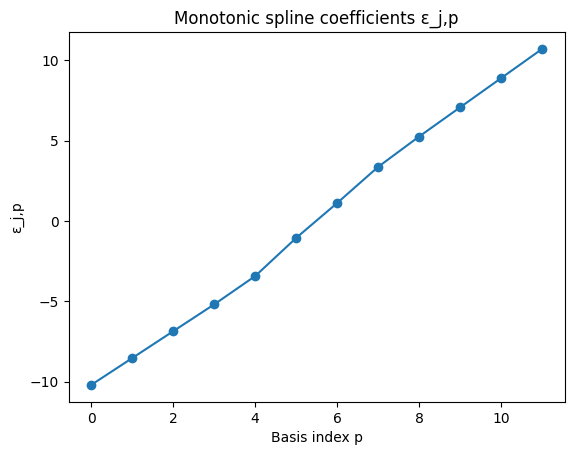

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0574,  -8.2911,  -6.5241,  -4.7569,  -2.9856,  -1.0521,   1.0588,
          3.1801,   5.3048,   7.3032,   9.1214,  10.9395])


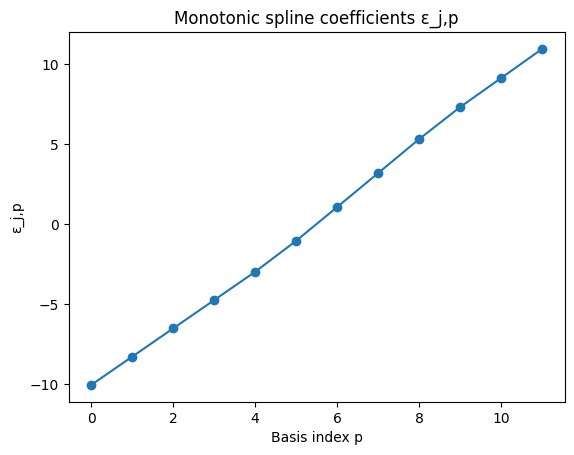

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2363,  -8.5801,  -6.9239,  -5.2676,  -3.4852,  -1.0418,   1.1241,
          3.1248,   5.0382,   6.8572,   8.6754,  10.4936])


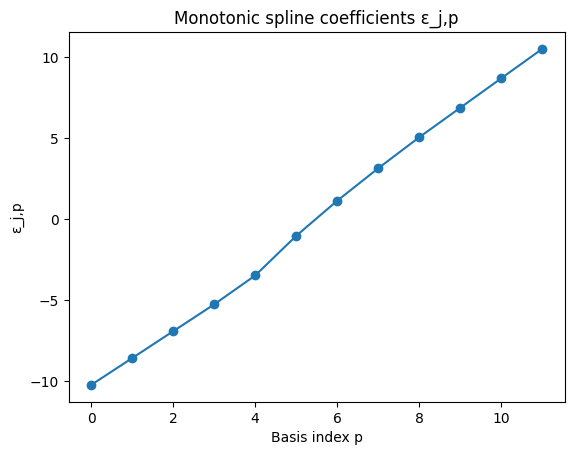

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0487,  -8.2745,  -6.5003,  -4.7263,  -2.9468,  -1.0192,   1.0798,
          3.1780,   5.2723,   7.3934,   9.2115,  11.0297])


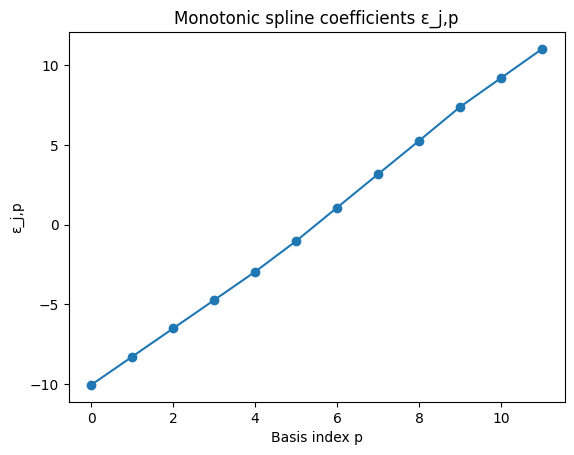

In [12]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

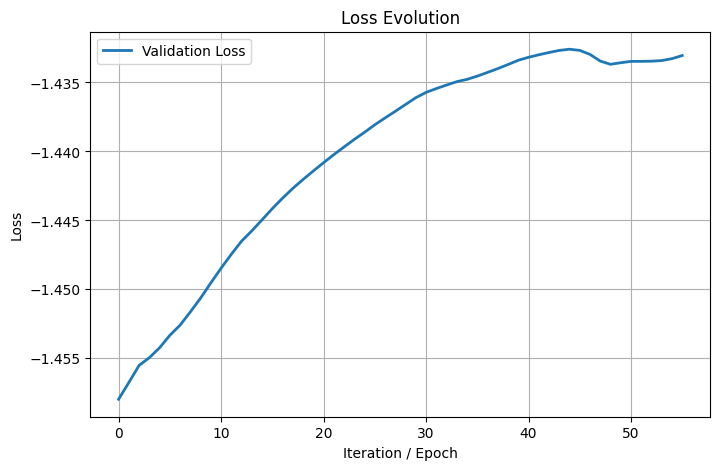

In [13]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#output.keys()

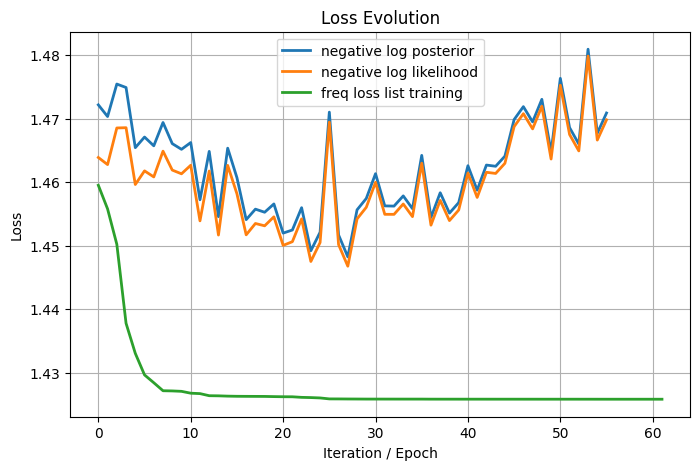

tensor(1.4259, grad_fn=<AddBackward0>)
1.4467836618423462


In [15]:
elbo_loss = output['loss_history']
neg_log_posterior = output["neg_log_posterior_bgtm"]
neg_log_likelihood = output['negative_log_likelihood']
negative_log_prior_decorrelation = output['negative_log_prior_decorrelation']
negative_log_prior_transformation = output['negative_log_prior_transformation']

neg_log_posterior_np = [t.detach().cpu().item() if torch.is_tensor(t) else t for t in neg_log_posterior]
neg_log_likelihood_np = [t.detach().cpu().item() if torch.is_tensor(t) else t for t in neg_log_likelihood]
negative_log_prior_decorrelation_np = [t.detach().cpu().item() if torch.is_tensor(t) else t for t in negative_log_prior_decorrelation]


##### FREQ #####

loss_list_training = output_freq["loss_list_training"]

# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(series(elbo_loss), label="elbo_loss", linewidth=2 )
plt.plot(series(neg_log_posterior), label="negative log posterior", linewidth=2)
plt.plot(series(neg_log_likelihood), label="negative log likelihood", linewidth=2)
#plt.plot(series(negative_log_prior_decorrelation), label="negative log prior decorrelation", linewidth=2) 
#plt.plot(series(negative_log_prior_transformation), label="negative log prior transformation", linewidth=2)

plt.plot(loss_list_training, label= "freq loss list training", linewidth=2 )

plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

print(output_freq['loss_with_penalties'])
print(min(neg_log_likelihood))

In [16]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-10.0574,   1.5789,   1.5795,   1.5799,   1.5849,   1.7772,   1.9817,
          1.9937,   1.9974,   1.8527,   1.6411,   1.6411, -10.0487,   1.5884,
          1.5883,   1.5881,   1.5947,   1.7704,   1.9683,   1.9673,   1.9628,
          1.9934,   1.6411,   1.6411], device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-10.0574,   1.5789,   1.5795,   1.5799,   1.5849,   1.7772,   1.9817,
          1.9937,   1.9974,   1.8527,   1.6411,   1.6411], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-10.0487,   1.5884,   1.5883,   1.5881,   1.5947,   1.7704,   1.9683,
          1.9673,   1.9628,   1.9934,   1.6411,   1.6411], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-10.2126,   1.4632,   1.4632,   1.4635,   1.5754,   2.2777,   2.0542,
          2.1393,   1.7261,   1.6413,   1.6411,   1.6411], requires_grad=True), Parameter cont

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [17]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [18]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [19]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.01
KLD GTM      Train Data:  -0.0017
KLD Gaussian Train Data:  -0.0007
KLD Copula   Train Data:  -0.0002

KLD BGTM      Test  Data:  0.0115
KLD GTM      Test  Data:  0.0012
KLD Gaussian Test  Data:  0.0005
KLD Copula   Test  Data:  0.0011


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [20]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

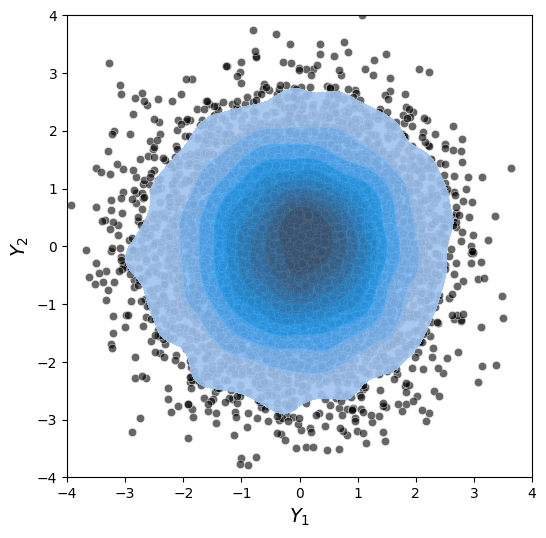

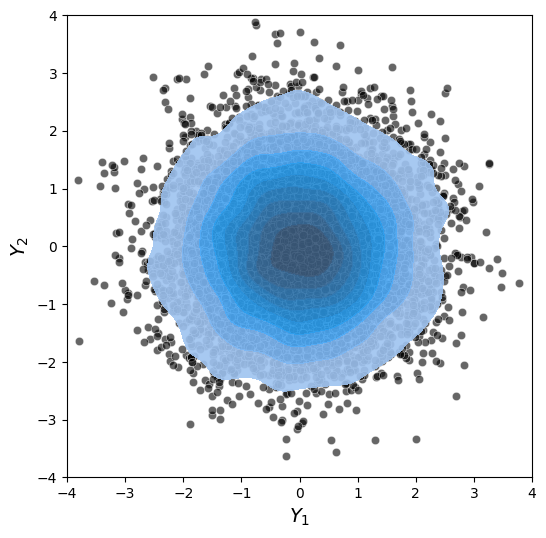

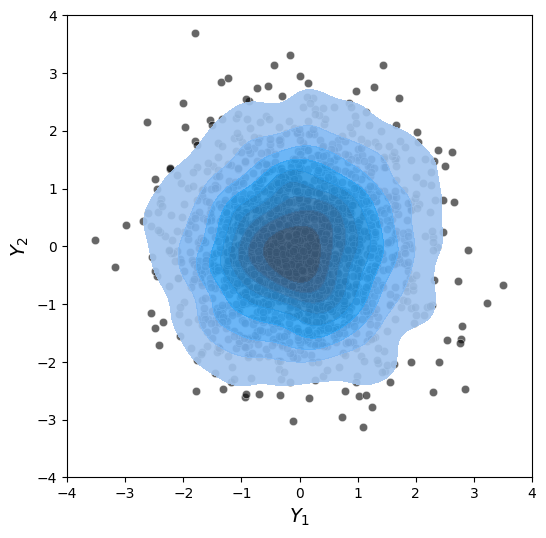

In [21]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [22]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

In [23]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### BGTM model

In [24]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


D = 24
First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:00<00:52,  3.79it/s]

ELPD change after μ-nudge: -284.07177734375
[1/200] train=41.5703  val_ELPD=-1.9343  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=1035.387508 rank=20  E_qf≈0.0448  tau*E[qf]≈46.36  Δ=-6.46e+01


  1%|          | 2/200 [00:00<00:47,  4.18it/s]

ELPD change after μ-nudge: -277.91015625
[2/200] train=40.5339  val_ELPD=-1.8902  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=977.2362658 rank=20  E_qf≈0.0448  tau*E[qf]≈43.76  Δ=-5.82e+01


  2%|▏         | 3/200 [00:00<01:03,  3.12it/s]

ELPD change after μ-nudge: -271.60302734375
[3/200] train=41.5518  val_ELPD=-1.8500  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=924.9001476 rank=20  E_qf≈0.0448  tau*E[qf]≈41.41  Δ=-5.23e+01


  2%|▏         | 4/200 [00:01<00:55,  3.53it/s]

ELPD change after μ-nudge: -265.0693359375
[4/200] train=34.8363  val_ELPD=-1.8137  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=877.7976412 rank=20  E_qf≈0.0448  tau*E[qf]≈39.3  Δ=-4.71e+01


  2%|▎         | 5/200 [00:01<00:51,  3.82it/s]

ELPD change after μ-nudge: -258.319091796875
[5/200] train=39.6562  val_ELPD=-1.7816  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=835.4053854 rank=20  E_qf≈0.0448  tau*E[qf]≈37.41  Δ=-4.24e+01


  3%|▎         | 6/200 [00:01<00:48,  4.02it/s]

ELPD change after μ-nudge: -251.36181640625
[6/200] train=35.4507  val_ELPD=-1.7534  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=797.2523552 rank=20  E_qf≈0.0448  tau*E[qf]≈35.7  Δ=-3.82e+01


  4%|▎         | 7/200 [00:01<00:46,  4.12it/s]

ELPD change after μ-nudge: -244.2421875
[7/200] train=37.7736  val_ELPD=-1.7289  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=762.914628 rank=20  E_qf≈0.0448  tau*E[qf]≈34.16  Δ=-3.43e+01


  4%|▍         | 8/200 [00:02<00:47,  4.00it/s]

ELPD change after μ-nudge: -237.034423828125
[8/200] train=36.4329  val_ELPD=-1.7081  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=732.0106735 rank=20  E_qf≈0.0448  tau*E[qf]≈32.78  Δ=-3.09e+01


  4%|▍         | 9/200 [00:02<00:46,  4.13it/s]

ELPD change after μ-nudge: -229.731201171875
[9/200] train=34.8506  val_ELPD=-1.6910  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=704.1971145 rank=20  E_qf≈0.0448  tau*E[qf]≈31.53  Δ=-2.78e+01


  5%|▌         | 10/200 [00:02<00:45,  4.21it/s]

ELPD change after μ-nudge: -222.24951171875
[10/200] train=35.2689  val_ELPD=-1.6773  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=679.1649114 rank=20  E_qf≈0.0448  tau*E[qf]≈30.41  Δ=-2.50e+01


  6%|▌         | 11/200 [00:02<00:47,  3.98it/s]

ELPD change after μ-nudge: -214.506591796875
[11/200] train=33.4950  val_ELPD=-1.6667  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=656.6359286 rank=20  E_qf≈0.0448  tau*E[qf]≈29.4  Δ=-2.25e+01


  6%|▌         | 12/200 [00:03<00:49,  3.82it/s]

ELPD change after μ-nudge: -206.58837890625
[12/200] train=36.2143  val_ELPD=-1.6588  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0632   tau4=636.3598441 rank=20  E_qf≈0.0448  tau*E[qf]≈28.49  Δ=-2.03e+01


  6%|▋         | 13/200 [00:03<00:50,  3.73it/s]

ELPD change after μ-nudge: -198.472900390625
[13/200] train=34.6770  val_ELPD=-1.6533  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=618.111368 rank=20  E_qf≈0.0448  tau*E[qf]≈27.68  Δ=-1.82e+01


  7%|▋         | 14/200 [00:03<00:50,  3.68it/s]

ELPD change after μ-nudge: -190.237060546875
[14/200] train=34.5688  val_ELPD=-1.6489  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=601.6877395 rank=20  E_qf≈0.0448  tau*E[qf]≈26.94  Δ=-1.64e+01


  8%|▊         | 15/200 [00:03<00:50,  3.64it/s]

ELPD change after μ-nudge: -182.235595703125
[15/200] train=32.0811  val_ELPD=-1.6402  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=586.9064739 rank=20  E_qf≈0.0448  tau*E[qf]≈26.28  Δ=-1.48e+01


  8%|▊         | 16/200 [00:04<00:50,  3.61it/s]

ELPD change after μ-nudge: -174.35009765625
[16/200] train=31.2484  val_ELPD=-1.6333  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=573.6033349 rank=20  E_qf≈0.0448  tau*E[qf]≈25.68  Δ=-1.33e+01


  8%|▊         | 17/200 [00:04<00:50,  3.59it/s]

ELPD change after μ-nudge: -166.46826171875
[17/200] train=33.7414  val_ELPD=-1.6281  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0696 σmin=0.0695 σmax=0.0696   tau4=561.6305097 rank=20  E_qf≈0.0448  tau*E[qf]≈25.15  Δ=-1.20e+01


  9%|▉         | 18/200 [00:04<00:51,  3.55it/s]

ELPD change after μ-nudge: -158.691650390625
[18/200] train=31.3787  val_ELPD=-1.6242  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=550.8549671 rank=20  E_qf≈0.0448  tau*E[qf]≈24.67  Δ=-1.08e+01


 10%|▉         | 19/200 [00:05<00:50,  3.55it/s]

ELPD change after μ-nudge: -150.946533203125
[19/200] train=31.0415  val_ELPD=-1.6214  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=541.1569787 rank=20  E_qf≈0.0448  tau*E[qf]≈24.23  Δ=-9.70e+00


 10%|█         | 20/200 [00:05<00:50,  3.54it/s]

ELPD change after μ-nudge: -143.38330078125
[20/200] train=30.8455  val_ELPD=-1.6190  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=532.4287892 rank=20  E_qf≈0.0448  tau*E[qf]≈23.84  Δ=-8.73e+00


 10%|█         | 21/200 [00:05<00:56,  3.15it/s]

ELPD change after μ-nudge: -136.11572265625
[21/200] train=30.5598  val_ELPD=-1.6168  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=524.5734186 rank=20  E_qf≈0.0448  tau*E[qf]≈23.49  Δ=-7.86e+00


 11%|█         | 22/200 [00:06<01:00,  2.92it/s]

ELPD change after μ-nudge: -129.155029296875
[22/200] train=29.8017  val_ELPD=-1.6149  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=517.5035851 rank=20  E_qf≈0.0448  tau*E[qf]≈23.17  Δ=-7.07e+00


 12%|█▏        | 23/200 [00:06<01:03,  2.78it/s]

ELPD change after μ-nudge: -122.628662109375
[23/200] train=28.1683  val_ELPD=-1.6135  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0780 σmax=0.0781   tau4=511.1407349 rank=20  E_qf≈0.0448  tau*E[qf]≈22.89  Δ=-6.36e+00


 12%|█▏        | 24/200 [00:06<01:05,  2.69it/s]

ELPD change after μ-nudge: -116.595703125
[24/200] train=29.9198  val_ELPD=-1.6127  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=505.4141697 rank=20  E_qf≈0.0448  tau*E[qf]≈22.63  Δ=-5.73e+00


 12%|█▎        | 25/200 [00:07<01:06,  2.62it/s]

ELPD change after μ-nudge: -111.048095703125
[25/200] train=28.6955  val_ELPD=-1.6119  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0812   tau4=500.2602611 rank=20  E_qf≈0.0448  tau*E[qf]≈22.4  Δ=-5.15e+00


 13%|█▎        | 26/200 [00:07<01:07,  2.58it/s]

ELPD change after μ-nudge: -106.28125
[26/200] train=27.3527  val_ELPD=-1.6094  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=495.6217433 rank=20  E_qf≈0.0448  tau*E[qf]≈22.19  Δ=-4.64e+00


 14%|█▎        | 27/200 [00:08<01:07,  2.55it/s]

ELPD change after μ-nudge: -102.095458984375
[27/200] train=28.4219  val_ELPD=-1.6068  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=491.4470773 rank=20  E_qf≈0.0448  tau*E[qf]≈22.01  Δ=-4.17e+00


 14%|█▍        | 28/200 [00:08<01:07,  2.53it/s]

ELPD change after μ-nudge: -98.595458984375
[28/200] train=27.5993  val_ELPD=-1.6044  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=487.6898779 rank=20  E_qf≈0.0448  tau*E[qf]≈21.84  Δ=-3.76e+00


 14%|█▍        | 29/200 [00:08<01:07,  2.52it/s]

ELPD change after μ-nudge: -95.7529296875
[29/200] train=26.5395  val_ELPD=-1.6021  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0876 σmin=0.0875 σmax=0.0876   tau4=484.3083985 rank=20  E_qf≈0.0448  tau*E[qf]≈21.69  Δ=-3.38e+00


 15%|█▌        | 30/200 [00:09<01:07,  2.51it/s]

ELPD change after μ-nudge: -93.617431640625
[30/200] train=25.8077  val_ELPD=-1.5999  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0893   tau4=481.265067 rank=20  E_qf≈0.0448  tau*E[qf]≈21.55  Δ=-3.04e+00


 16%|█▌        | 31/200 [00:10<01:19,  2.12it/s]

ELPD change after μ-nudge: -91.970703125
[31/200] train=25.1615  val_ELPD=-1.5979  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0910 σmin=0.0909 σmax=0.0910   tau4=478.5260686 rank=20  E_qf≈0.0448  tau*E[qf]≈21.43  Δ=-2.74e+00


 16%|█▌        | 32/200 [00:10<01:27,  1.92it/s]

ELPD change after μ-nudge: -90.888427734375
[32/200] train=25.0499  val_ELPD=-1.5960  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0928   tau4=476.0609701 rank=20  E_qf≈0.0448  tau*E[qf]≈21.32  Δ=-2.47e+00


 16%|█▋        | 33/200 [00:11<01:33,  1.79it/s]

ELPD change after μ-nudge: -90.492919921875
[33/200] train=24.3166  val_ELPD=-1.5942  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=473.8423814 rank=20  E_qf≈0.0448  tau*E[qf]≈21.22  Δ=-2.22e+00


 17%|█▋        | 34/200 [00:11<01:36,  1.72it/s]

ELPD change after μ-nudge: -90.643310546875
[34/200] train=24.4324  val_ELPD=-1.5924  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=471.8456516 rank=20  E_qf≈0.0448  tau*E[qf]≈21.13  Δ=-2.00e+00


 18%|█▊        | 35/200 [00:12<01:39,  1.66it/s]

ELPD change after μ-nudge: -91.34521484375
[35/200] train=24.2555  val_ELPD=-1.5907  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0982   tau4=470.0485948 rank=20  E_qf≈0.0448  tau*E[qf]≈21.05  Δ=-1.80e+00


 18%|█▊        | 36/200 [00:13<01:40,  1.63it/s]

ELPD change after μ-nudge: -92.4873046875
[36/200] train=23.3626  val_ELPD=-1.5890  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1001   tau4=468.4312436 rank=20  E_qf≈0.0448  tau*E[qf]≈20.97  Δ=-1.62e+00


 18%|█▊        | 37/200 [00:13<01:43,  1.57it/s]

ELPD change after μ-nudge: -94.09423828125
[37/200] train=22.5714  val_ELPD=-1.5873  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1020   tau4=466.9756276 rank=20  E_qf≈0.0448  tau*E[qf]≈20.91  Δ=-1.46e+00


 19%|█▉        | 38/200 [00:14<01:43,  1.57it/s]

ELPD change after μ-nudge: -96.060546875
[38/200] train=22.3039  val_ELPD=-1.5855  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1039 σmin=0.1038 σmax=0.1039   tau4=465.6655732 rank=20  E_qf≈0.0448  tau*E[qf]≈20.85  Δ=-1.31e+00


 20%|█▉        | 39/200 [00:15<01:43,  1.55it/s]

ELPD change after μ-nudge: -98.41796875
[39/200] train=22.2111  val_ELPD=-1.5837  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1059   tau4=464.4865242 rank=20  E_qf≈0.0448  tau*E[qf]≈20.8  Δ=-1.18e+00


 20%|██        | 40/200 [00:15<01:43,  1.55it/s]

ELPD change after μ-nudge: -101.06298828125
[40/200] train=21.7092  val_ELPD=-1.5818  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1079   tau4=463.4253801 rank=20  E_qf≈0.0448  tau*E[qf]≈20.75  Δ=-1.06e+00


 20%|██        | 41/200 [00:16<02:05,  1.27it/s]

ELPD change after μ-nudge: -104.029296875
[41/200] train=21.1889  val_ELPD=-1.5798  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1100   tau4=462.4703504 rank=20  E_qf≈0.0448  tau*E[qf]≈20.71  Δ=-9.55e-01


 21%|██        | 42/200 [00:18<02:21,  1.12it/s]

ELPD change after μ-nudge: -107.21728515625
[42/200] train=20.9469  val_ELPD=-1.5778  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1120 σmin=0.1119 σmax=0.1120   tau4=461.6108237 rank=20  E_qf≈0.0448  tau*E[qf]≈20.67  Δ=-8.60e-01


 22%|██▏       | 43/200 [00:19<02:33,  1.03it/s]

ELPD change after μ-nudge: -110.692626953125
[43/200] train=20.3113  val_ELPD=-1.5758  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1142   tau4=460.8372497 rank=20  E_qf≈0.0448  tau*E[qf]≈20.63  Δ=-7.74e-01


 22%|██▏       | 44/200 [00:20<02:40,  1.03s/it]

ELPD change after μ-nudge: -114.217041015625
[44/200] train=19.9665  val_ELPD=-1.5737  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1163   tau4=460.1410331 rank=20  E_qf≈0.0448  tau*E[qf]≈20.6  Δ=-6.96e-01


 22%|██▎       | 45/200 [00:21<02:46,  1.07s/it]

ELPD change after μ-nudge: -117.920654296875
[45/200] train=19.1372  val_ELPD=-1.5717  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1184 σmax=0.1185   tau4=459.5144381 rank=20  E_qf≈0.0448  tau*E[qf]≈20.58  Δ=-6.27e-01


 23%|██▎       | 46/200 [00:22<02:48,  1.09s/it]

ELPD change after μ-nudge: -121.83984375
[46/200] train=19.2487  val_ELPD=-1.5697  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1207 σmin=0.1206 σmax=0.1207   tau4=458.9505026 rank=20  E_qf≈0.0448  tau*E[qf]≈20.55  Δ=-5.64e-01


 24%|██▎       | 47/200 [00:23<02:48,  1.10s/it]

ELPD change after μ-nudge: -125.7734375
[47/200] train=17.8867  val_ELPD=-1.5677  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1229 σmax=0.1230   tau4=458.4429607 rank=20  E_qf≈0.0448  tau*E[qf]≈20.53  Δ=-5.08e-01


 24%|██▍       | 48/200 [00:25<02:49,  1.11s/it]

ELPD change after μ-nudge: -129.6669921875
[48/200] train=18.5858  val_ELPD=-1.5658  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1252 σmax=0.1253   tau4=457.986173 rank=20  E_qf≈0.0448  tau*E[qf]≈20.51  Δ=-4.57e-01


 24%|██▍       | 49/200 [00:26<02:48,  1.12s/it]

ELPD change after μ-nudge: -133.539794921875
[49/200] train=17.4928  val_ELPD=-1.5639  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1276 σmin=0.1275 σmax=0.1277   tau4=457.575064 rank=20  E_qf≈0.0448  tau*E[qf]≈20.49  Δ=-4.11e-01


 25%|██▌       | 50/200 [00:27<02:49,  1.13s/it]

ELPD change after μ-nudge: -137.40869140625
[50/200] train=17.1366  val_ELPD=-1.5620  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1300 σmin=0.1299 σmax=0.1300   tau4=457.2050659 rank=20  E_qf≈0.0448  tau*E[qf]≈20.47  Δ=-3.70e-01


 26%|██▌       | 51/200 [00:28<02:49,  1.14s/it]

ELPD change after μ-nudge: -140.9814453125
[51/200] train=16.7012  val_ELPD=-1.5602  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1324 σmin=0.1323 σmax=0.1325   tau4=456.8720677 rank=20  E_qf≈0.0448  tau*E[qf]≈20.46  Δ=-3.33e-01


 26%|██▌       | 52/200 [00:30<03:13,  1.30s/it]

ELPD change after μ-nudge: -144.684814453125
[52/200] train=16.2463  val_ELPD=-1.5585  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1348 σmin=0.1348 σmax=0.1349   tau4=456.5723692 rank=20  E_qf≈0.0448  tau*E[qf]≈20.44  Δ=-3.00e-01


 26%|██▋       | 53/200 [00:31<03:04,  1.25s/it]

ELPD change after μ-nudge: -148.20361328125
[53/200] train=15.3517  val_ELPD=-1.5568  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1373 σmin=0.1373 σmax=0.1374   tau4=456.3026407 rank=20  E_qf≈0.0448  tau*E[qf]≈20.43  Δ=-2.70e-01


 27%|██▋       | 54/200 [00:32<02:58,  1.22s/it]

ELPD change after μ-nudge: -151.701171875
[54/200] train=15.1500  val_ELPD=-1.5551  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1399 σmin=0.1398 σmax=0.1400   tau4=456.0598849 rank=20  E_qf≈0.0448  tau*E[qf]≈20.42  Δ=-2.43e-01


 28%|██▊       | 55/200 [00:33<02:55,  1.21s/it]

ELPD change after μ-nudge: -155.3330078125
[55/200] train=15.4368  val_ELPD=-1.5535  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1425 σmin=0.1424 σmax=0.1426   tau4=455.8414048 rank=20  E_qf≈0.0448  tau*E[qf]≈20.41  Δ=-2.18e-01


 28%|██▊       | 56/200 [00:34<02:58,  1.24s/it]

ELPD change after μ-nudge: -159.026611328125
[56/200] train=14.3446  val_ELPD=-1.5520  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1451 σmin=0.1450 σmax=0.1452   tau4=455.6447726 rank=20  E_qf≈0.0448  tau*E[qf]≈20.4  Δ=-1.97e-01


 28%|██▊       | 57/200 [00:36<02:53,  1.21s/it]

ELPD change after μ-nudge: -162.760986328125
[57/200] train=14.4209  val_ELPD=-1.5504  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1478 σmin=0.1477 σmax=0.1479   tau4=455.4678037 rank=20  E_qf≈0.0448  tau*E[qf]≈20.39  Δ=-1.77e-01


 29%|██▉       | 58/200 [00:37<02:48,  1.19s/it]

ELPD change after μ-nudge: -166.21044921875
[58/200] train=13.2179  val_ELPD=-1.5490  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1505 σmin=0.1504 σmax=0.1506   tau4=455.3085317 rank=20  E_qf≈0.0448  tau*E[qf]≈20.39  Δ=-1.59e-01


 30%|██▉       | 59/200 [00:38<02:45,  1.17s/it]

ELPD change after μ-nudge: -169.40283203125
[59/200] train=13.2621  val_ELPD=-1.5476  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1533 σmin=0.1531 σmax=0.1534   tau4=455.1651868 rank=20  E_qf≈0.0448  tau*E[qf]≈20.38  Δ=-1.43e-01


 30%|███       | 60/200 [00:39<02:42,  1.16s/it]

ELPD change after μ-nudge: -172.852783203125
[60/200] train=13.0282  val_ELPD=-1.5462  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1561 σmin=0.1559 σmax=0.1562   tau4=455.0361765 rank=20  E_qf≈0.0448  tau*E[qf]≈20.38  Δ=-1.29e-01


 30%|███       | 61/200 [00:40<02:40,  1.16s/it]

ELPD change after μ-nudge: -176.67724609375
[61/200] train=12.3228  val_ELPD=-1.5447  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1589 σmin=0.1588 σmax=0.1590   tau4=454.9200672 rank=20  E_qf≈0.0448  tau*E[qf]≈20.37  Δ=-1.16e-01


 31%|███       | 62/200 [00:41<02:38,  1.15s/it]

ELPD change after μ-nudge: -180.68505859375
[62/200] train=12.4441  val_ELPD=-1.5433  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1618 σmin=0.1617 σmax=0.1619   tau4=454.8155688 rank=20  E_qf≈0.0448  tau*E[qf]≈20.37  Δ=-1.04e-01


 32%|███▏      | 63/200 [00:42<02:37,  1.15s/it]

ELPD change after μ-nudge: -184.610595703125
[63/200] train=11.4764  val_ELPD=-1.5419  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1648 σmin=0.1646 σmax=0.1649   tau4=454.7215202 rank=20  E_qf≈0.0448  tau*E[qf]≈20.36  Δ=-9.40e-02


 32%|███▏      | 64/200 [00:44<02:36,  1.15s/it]

ELPD change after μ-nudge: -188.445556640625
[64/200] train=10.4970  val_ELPD=-1.5406  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1678 σmin=0.1676 σmax=0.1679   tau4=454.6368766 rank=20  E_qf≈0.0448  tau*E[qf]≈20.36  Δ=-8.46e-02


 32%|███▎      | 65/200 [00:45<02:35,  1.15s/it]

ELPD change after μ-nudge: -192.40478515625
[65/200] train=10.1661  val_ELPD=-1.5392  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1708 σmin=0.1706 σmax=0.1709   tau4=454.5606972 rank=20  E_qf≈0.0448  tau*E[qf]≈20.35  Δ=-7.62e-02


 33%|███▎      | 66/200 [00:46<02:33,  1.15s/it]

ELPD change after μ-nudge: -196.332763671875
[66/200] train=10.4516  val_ELPD=-1.5379  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1739 σmin=0.1737 σmax=0.1740   tau4=454.4921358 rank=20  E_qf≈0.0448  tau*E[qf]≈20.35  Δ=-6.86e-02


 34%|███▎      | 67/200 [00:47<02:32,  1.15s/it]

ELPD change after μ-nudge: -200.280517578125
[67/200] train=9.8348  val_ELPD=-1.5365  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1770 σmin=0.1768 σmax=0.1772   tau4=454.4304306 rank=20  E_qf≈0.0448  tau*E[qf]≈20.35  Δ=-6.17e-02


 34%|███▍      | 68/200 [00:48<02:39,  1.21s/it]

ELPD change after μ-nudge: -204.24365234375
[68/200] train=8.7061  val_ELPD=-1.5351  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1802 σmin=0.1800 σmax=0.1803   tau4=454.3748959 rank=20  E_qf≈0.0448  tau*E[qf]≈20.35  Δ=-5.55e-02


 34%|███▍      | 69/200 [00:50<02:37,  1.20s/it]

ELPD change after μ-nudge: -207.8359375
[69/200] train=9.4832  val_ELPD=-1.5338  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1835 σmin=0.1833 σmax=0.1836   tau4=454.3249146 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-5.00e-02


 35%|███▌      | 70/200 [00:51<02:33,  1.18s/it]

ELPD change after μ-nudge: -212.120849609375
[70/200] train=8.1308  val_ELPD=-1.5323  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1868 σmin=0.1865 σmax=0.1869   tau4=454.2799315 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-4.50e-02


 36%|███▌      | 71/200 [00:52<02:30,  1.17s/it]

ELPD change after μ-nudge: -217.384033203125
[71/200] train=7.8070  val_ELPD=-1.5307  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1901 σmin=0.1899 σmax=0.1902   tau4=454.2394467 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-4.05e-02


 36%|███▌      | 72/200 [00:53<02:28,  1.16s/it]

ELPD change after μ-nudge: -223.0556640625
[72/200] train=7.2837  val_ELPD=-1.5290  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1935 σmin=0.1932 σmax=0.1936   tau4=454.2030103 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-3.64e-02


 36%|███▋      | 73/200 [00:54<02:26,  1.15s/it]

ELPD change after μ-nudge: -228.5673828125
[73/200] train=7.8910  val_ELPD=-1.5275  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1969 σmin=0.1966 σmax=0.1971   tau4=454.1702176 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-3.28e-02


 37%|███▋      | 74/200 [00:55<02:24,  1.15s/it]

ELPD change after μ-nudge: -234.60400390625
[74/200] train=7.4370  val_ELPD=-1.5260  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2004 σmin=0.2001 σmax=0.2006   tau4=454.1407042 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-2.95e-02


 38%|███▊      | 75/200 [00:56<02:23,  1.15s/it]

ELPD change after μ-nudge: -240.51904296875
[75/200] train=5.7863  val_ELPD=-1.5246  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2039 σmin=0.2036 σmax=0.2041   tau4=454.1141421 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-2.66e-02


 38%|███▊      | 76/200 [00:58<02:21,  1.14s/it]

ELPD change after μ-nudge: -245.75
[76/200] train=5.5587  val_ELPD=-1.5233  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2075 σmin=0.2072 σmax=0.2077   tau4=454.0902363 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-2.39e-02


 38%|███▊      | 77/200 [00:59<02:20,  1.14s/it]

ELPD change after μ-nudge: -251.21484375
[77/200] train=6.0218  val_ELPD=-1.5219  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2112 σmin=0.2108 σmax=0.2114   tau4=454.068721 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-2.15e-02


 39%|███▉      | 78/200 [01:00<02:19,  1.14s/it]

ELPD change after μ-nudge: -256.613037109375
[78/200] train=4.7511  val_ELPD=-1.5206  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2149 σmin=0.2144 σmax=0.2151   tau4=454.0493572 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.94e-02


 40%|███▉      | 79/200 [01:01<02:18,  1.14s/it]

ELPD change after μ-nudge: -261.18212890625
[79/200] train=4.8790  val_ELPD=-1.5194  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2186 σmin=0.2182 σmax=0.2189   tau4=454.0319298 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.74e-02


 40%|████      | 80/200 [01:02<02:17,  1.14s/it]

ELPD change after μ-nudge: -266.087158203125
[80/200] train=4.4160  val_ELPD=-1.5181  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2224 σmin=0.2219 σmax=0.2227   tau4=454.0162452 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.57e-02


 40%|████      | 81/200 [01:03<02:22,  1.20s/it]

ELPD change after μ-nudge: -270.18310546875
[81/200] train=3.8109  val_ELPD=-1.5168  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2263 σmin=0.2258 σmax=0.2266   tau4=454.002129 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.41e-02


 41%|████      | 82/200 [01:05<02:19,  1.18s/it]

ELPD change after μ-nudge: -274.580322265625
[82/200] train=3.0113  val_ELPD=-1.5156  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2302 σmin=0.2297 σmax=0.2305   tau4=453.9894244 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.27e-02


 42%|████▏     | 83/200 [01:06<02:17,  1.17s/it]

ELPD change after μ-nudge: -278.830810546875
[83/200] train=3.1260  val_ELPD=-1.5144  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2342 σmin=0.2336 σmax=0.2345   tau4=453.9779903 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.14e-02


 42%|████▏     | 84/200 [01:07<02:14,  1.16s/it]

ELPD change after μ-nudge: -283.831787109375
[84/200] train=1.9253  val_ELPD=-1.5132  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2382 σmin=0.2376 σmax=0.2386   tau4=453.9676996 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.03e-02


 42%|████▎     | 85/200 [01:08<02:12,  1.16s/it]

ELPD change after μ-nudge: -289.281005859375
[85/200] train=2.3078  val_ELPD=-1.5119  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2423 σmin=0.2416 σmax=0.2427   tau4=453.958438 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-9.26e-03


 43%|████▎     | 86/200 [01:09<02:11,  1.16s/it]

ELPD change after μ-nudge: -294.838134765625
[86/200] train=2.1083  val_ELPD=-1.5105  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2464 σmin=0.2458 σmax=0.2468   tau4=453.9501025 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-8.34e-03


 44%|████▎     | 87/200 [01:10<02:10,  1.15s/it]

ELPD change after μ-nudge: -299.524169921875
[87/200] train=0.8564  val_ELPD=-1.5092  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2506 σmin=0.2499 σmax=0.2511   tau4=453.9426006 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-7.50e-03


 44%|████▍     | 88/200 [01:11<02:08,  1.15s/it]

ELPD change after μ-nudge: -304.0029296875
[88/200] train=0.8881  val_ELPD=-1.5080  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2549 σmin=0.2541 σmax=0.2553   tau4=453.9358489 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-6.75e-03


 44%|████▍     | 89/200 [01:13<02:07,  1.15s/it]

ELPD change after μ-nudge: -309.4384765625
[89/200] train=0.3328  val_ELPD=-1.5068  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2592 σmin=0.2584 σmax=0.2597   tau4=453.9297723 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-6.08e-03


 45%|████▌     | 90/200 [01:14<02:05,  1.14s/it]

ELPD change after μ-nudge: -317.314697265625
[90/200] train=-0.3716  val_ELPD=-1.5054  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2635 σmin=0.2627 σmax=0.2641   tau4=453.9243034 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-5.47e-03


 46%|████▌     | 91/200 [01:15<02:04,  1.14s/it]

ELPD change after μ-nudge: -324.5966796875
[91/200] train=-0.3563  val_ELPD=-1.5041  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2680 σmin=0.2671 σmax=0.2685   tau4=453.9193814 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-4.92e-03


 46%|████▌     | 92/200 [01:16<02:03,  1.14s/it]

ELPD change after μ-nudge: -331.00146484375
[92/200] train=-0.4058  val_ELPD=-1.5027  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2724 σmin=0.2715 σmax=0.2731   tau4=453.9149516 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.43e-03


 46%|████▋     | 93/200 [01:17<02:02,  1.14s/it]

ELPD change after μ-nudge: -337.382568359375
[93/200] train=-0.9965  val_ELPD=-1.5014  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2770 σmin=0.2760 σmax=0.2776   tau4=453.9109648 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.99e-03


 47%|████▋     | 94/200 [01:18<02:00,  1.14s/it]

ELPD change after μ-nudge: -344.57275390625
[94/200] train=-2.0262  val_ELPD=-1.5001  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2816 σmin=0.2806 σmax=0.2823   tau4=453.9073766 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.59e-03


 48%|████▊     | 95/200 [01:19<01:59,  1.14s/it]

ELPD change after μ-nudge: -352.39794921875
[95/200] train=-1.9148  val_ELPD=-1.4986  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2862 σmin=0.2852 σmax=0.2870   tau4=453.9041473 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.23e-03


 48%|████▊     | 96/200 [01:21<01:58,  1.14s/it]

ELPD change after μ-nudge: -361.301513671875
[96/200] train=-2.3077  val_ELPD=-1.4972  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2910 σmin=0.2898 σmax=0.2918   tau4=453.9012409 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.91e-03


 48%|████▊     | 97/200 [01:22<01:57,  1.14s/it]

ELPD change after μ-nudge: -371.505859375
[97/200] train=-2.9609  val_ELPD=-1.4958  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2957 σmin=0.2945 σmax=0.2966   tau4=453.8986252 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.62e-03


 49%|████▉     | 98/200 [01:23<01:56,  1.14s/it]

ELPD change after μ-nudge: -382.846923828125
[98/200] train=-2.5885  val_ELPD=-1.4945  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3006 σmin=0.2993 σmax=0.3015   tau4=453.896271 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.35e-03


 50%|████▉     | 99/200 [01:24<01:55,  1.14s/it]

ELPD change after μ-nudge: -396.736572265625
[99/200] train=-3.9210  val_ELPD=-1.4933  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3055 σmin=0.3041 σmax=0.3064   tau4=453.8941522 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.12e-03


 50%|█████     | 100/200 [01:25<01:54,  1.14s/it]

ELPD change after μ-nudge: -409.985595703125
[100/200] train=-4.1504  val_ELPD=-1.4922  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3104 σmin=0.3090 σmax=0.3114   tau4=453.8922453 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.91e-03


 50%|█████     | 101/200 [01:26<01:52,  1.14s/it]

ELPD change after μ-nudge: -420.5908203125
[101/200] train=-4.1830  val_ELPD=-1.4912  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3154 σmin=0.3139 σmax=0.3165   tau4=453.8905291 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.72e-03


 51%|█████     | 102/200 [01:27<01:52,  1.15s/it]

ELPD change after μ-nudge: -431.370361328125
[102/200] train=-4.3270  val_ELPD=-1.4901  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3205 σmin=0.3189 σmax=0.3216   tau4=453.8889846 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.54e-03


 52%|█████▏    | 103/200 [01:29<01:51,  1.15s/it]

ELPD change after μ-nudge: -441.0458984375
[103/200] train=-4.7846  val_ELPD=-1.4891  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3257 σmin=0.3240 σmax=0.3268   tau4=453.8875944 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.39e-03


 52%|█████▏    | 104/200 [01:30<01:50,  1.15s/it]

ELPD change after μ-nudge: -448.7265625
[104/200] train=-5.1077  val_ELPD=-1.4881  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3308 σmin=0.3291 σmax=0.3321   tau4=453.8863433 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.25e-03


 52%|█████▎    | 105/200 [01:31<01:48,  1.15s/it]

ELPD change after μ-nudge: -455.196044921875
[105/200] train=-5.4666  val_ELPD=-1.4871  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3361 σmin=0.3342 σmax=0.3374   tau4=453.8852173 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.13e-03


 53%|█████▎    | 106/200 [01:32<01:47,  1.14s/it]

ELPD change after μ-nudge: -464.533447265625
[106/200] train=-6.2905  val_ELPD=-1.4861  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3414 σmin=0.3394 σmax=0.3428   tau4=453.8842039 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.01e-03


 54%|█████▎    | 107/200 [01:33<01:46,  1.14s/it]

ELPD change after μ-nudge: -472.02099609375
[107/200] train=-6.6555  val_ELPD=-1.4851  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3468 σmin=0.3447 σmax=0.3483   tau4=453.8832919 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-9.12e-04


 54%|█████▍    | 108/200 [01:34<01:44,  1.14s/it]

ELPD change after μ-nudge: -479.04296875
[108/200] train=-7.1400  val_ELPD=-1.4842  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3522 σmin=0.3500 σmax=0.3538   tau4=453.882471 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-8.21e-04


 55%|█████▍    | 109/200 [01:35<01:43,  1.14s/it]

ELPD change after μ-nudge: -484.505615234375
[109/200] train=-7.0189  val_ELPD=-1.4834  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3577 σmin=0.3553 σmax=0.3594   tau4=453.8817323 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-7.39e-04


 55%|█████▌    | 110/200 [01:37<01:42,  1.14s/it]

ELPD change after μ-nudge: -492.633544921875
[110/200] train=-7.0694  val_ELPD=-1.4825  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3633 σmin=0.3607 σmax=0.3650   tau4=453.8810674 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-6.65e-04


 56%|█████▌    | 111/200 [01:38<01:41,  1.14s/it]

ELPD change after μ-nudge: -498.553466796875
[111/200] train=-7.2545  val_ELPD=-1.4817  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3689 σmin=0.3662 σmax=0.3707   tau4=453.880469 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-5.98e-04


 56%|█████▌    | 112/200 [01:39<01:40,  1.14s/it]

ELPD change after μ-nudge: -501.663818359375
[112/200] train=-8.2986  val_ELPD=-1.4812  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3746 σmin=0.3717 σmax=0.3765   tau4=453.8799304 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-5.39e-04


 56%|█████▋    | 113/200 [01:40<01:39,  1.15s/it]

ELPD change after μ-nudge: -504.7109375
[113/200] train=-8.5817  val_ELPD=-1.4808  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3803 σmin=0.3772 σmax=0.3824   tau4=453.8794457 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.85e-04


 57%|█████▋    | 114/200 [01:41<01:40,  1.17s/it]

ELPD change after μ-nudge: -508.543701171875
[114/200] train=-8.8383  val_ELPD=-1.4803  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3861 σmin=0.3828 σmax=0.3883   tau4=453.8790095 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.36e-04


 57%|█████▊    | 115/200 [01:42<01:39,  1.17s/it]

ELPD change after μ-nudge: -518.39697265625
[115/200] train=-9.9418  val_ELPD=-1.4796  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3919 σmin=0.3885 σmax=0.3942   tau4=453.8786169 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.93e-04


 58%|█████▊    | 116/200 [01:44<01:37,  1.16s/it]

ELPD change after μ-nudge: -529.107421875
[116/200] train=-9.3558  val_ELPD=-1.4789  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3979 σmin=0.3942 σmax=0.4003   tau4=453.8782635 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.53e-04


 58%|█████▊    | 117/200 [01:45<01:35,  1.15s/it]

ELPD change after μ-nudge: -539.53955078125
[117/200] train=-9.1548  val_ELPD=-1.4782  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4038 σmin=0.4000 σmax=0.4064   tau4=453.8779455 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.18e-04


 59%|█████▉    | 118/200 [01:46<01:34,  1.15s/it]

ELPD change after μ-nudge: -551.01416015625
[118/200] train=-10.7448  val_ELPD=-1.4775  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4099 σmin=0.4058 σmax=0.4125   tau4=453.8776593 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.86e-04


 60%|█████▉    | 119/200 [01:47<01:43,  1.28s/it]

ELPD change after μ-nudge: -563.2041015625
[119/200] train=-10.7279  val_ELPD=-1.4768  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4159 σmin=0.4117 σmax=0.4188   tau4=453.8774017 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.58e-04


 60%|██████    | 120/200 [01:49<01:44,  1.30s/it]

ELPD change after μ-nudge: -574.662841796875
[120/200] train=-10.9927  val_ELPD=-1.4763  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4221 σmin=0.4176 σmax=0.4251   tau4=453.8771698 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.32e-04


 60%|██████    | 121/200 [01:50<01:38,  1.25s/it]

ELPD change after μ-nudge: -588.21044921875
[121/200] train=-11.5733  val_ELPD=-1.4756  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4283 σmin=0.4236 σmax=0.4314   tau4=453.8769612 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.09e-04


 61%|██████    | 122/200 [01:51<01:35,  1.22s/it]

ELPD change after μ-nudge: -598.460693359375
[122/200] train=-10.9433  val_ELPD=-1.4751  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4346 σmin=0.4296 σmax=0.4378   tau4=453.8767734 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.88e-04


 62%|██████▏   | 123/200 [01:52<01:32,  1.20s/it]

ELPD change after μ-nudge: -617.065185546875
[123/200] train=-12.2218  val_ELPD=-1.4743  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4409 σmin=0.4356 σmax=0.4443   tau4=453.8766044 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.69e-04


 62%|██████▏   | 124/200 [01:53<01:29,  1.18s/it]

ELPD change after μ-nudge: -640.279296875
[124/200] train=-12.7380  val_ELPD=-1.4733  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4473 σmin=0.4417 σmax=0.4509   tau4=453.8764523 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.52e-04


 62%|██████▎   | 125/200 [01:54<01:28,  1.18s/it]

ELPD change after μ-nudge: -660.983154296875
[125/200] train=-12.1869  val_ELPD=-1.4725  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4537 σmin=0.4478 σmax=0.4575   tau4=453.8763154 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.37e-04


 63%|██████▎   | 126/200 [01:56<01:27,  1.18s/it]

ELPD change after μ-nudge: -688.931640625
[126/200] train=-12.1211  val_ELPD=-1.4714  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4602 σmin=0.4540 σmax=0.4642   tau4=453.8761922 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.23e-04


 64%|██████▎   | 127/200 [01:57<01:25,  1.17s/it]

ELPD change after μ-nudge: -718.38916015625
[127/200] train=-13.2425  val_ELPD=-1.4707  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4668 σmin=0.4603 σmax=0.4709   tau4=453.8760813 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.11e-04


 64%|██████▍   | 128/200 [01:58<01:23,  1.16s/it]

ELPD change after μ-nudge: -751.229248046875
[128/200] train=-13.8909  val_ELPD=-1.4700  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4734 σmin=0.4665 σmax=0.4777   tau4=453.8759815 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-9.98e-05


 64%|██████▍   | 129/200 [01:59<01:22,  1.16s/it]

ELPD change after μ-nudge: -785.589599609375
[129/200] train=-13.9422  val_ELPD=-1.4696  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4800 σmin=0.4728 σmax=0.4846   tau4=453.8758917 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-8.98e-05


 65%|██████▌   | 130/200 [02:00<01:24,  1.21s/it]

ELPD change after μ-nudge: -815.625244140625
[130/200] train=-14.6051  val_ELPD=-1.4695  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4867 σmin=0.4792 σmax=0.4915   tau4=453.8758109 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-8.08e-05


 66%|██████▌   | 131/200 [02:02<01:22,  1.19s/it]

ELPD change after μ-nudge: -840.1298828125
[131/200] train=-14.0511  val_ELPD=-1.4694  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4935 σmin=0.4856 σmax=0.4985   tau4=453.8757381 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-7.28e-05


 66%|██████▌   | 132/200 [02:03<01:20,  1.18s/it]

ELPD change after μ-nudge: -865.173095703125
[132/200] train=-15.2945  val_ELPD=-1.4694  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5003 σmin=0.4921 σmax=0.5056   tau4=453.8756726 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-6.55e-05


 66%|██████▋   | 133/200 [02:04<01:18,  1.17s/it]

ELPD change after μ-nudge: -889.733154296875
[133/200] train=-15.4311  val_ELPD=-1.4696  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5072 σmin=0.4986 σmax=0.5127   tau4=453.8756137 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-5.89e-05


 67%|██████▋   | 134/200 [02:05<01:16,  1.16s/it]

ELPD change after μ-nudge: -909.080810546875
[134/200] train=-15.5922  val_ELPD=-1.4696  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5142 σmin=0.5051 σmax=0.5199   tau4=453.8755607 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-5.30e-05


 68%|██████▊   | 135/200 [02:06<01:14,  1.15s/it]

ELPD change after μ-nudge: -922.80224609375
[135/200] train=-16.1137  val_ELPD=-1.4696  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5212 σmin=0.5117 σmax=0.5271   tau4=453.8755129 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.77e-05


 68%|██████▊   | 136/200 [02:07<01:13,  1.15s/it]

ELPD change after μ-nudge: -927.8408203125
[136/200] train=-16.3457  val_ELPD=-1.4697  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5282 σmin=0.5184 σmax=0.5344   tau4=453.87547 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.30e-05


 68%|██████▊   | 137/200 [02:08<01:12,  1.15s/it]

ELPD change after μ-nudge: -931.58349609375
[137/200] train=-15.8960  val_ELPD=-1.4700  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5353 σmin=0.5250 σmax=0.5418   tau4=453.8754313 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.87e-05


 69%|██████▉   | 138/200 [02:10<01:11,  1.15s/it]

ELPD change after μ-nudge: -943.328369140625
[138/200] train=-16.4453  val_ELPD=-1.4703  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.5424 σmin=0.5317 σmax=0.5492   tau4=453.8753965 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.48e-05


 70%|██████▉   | 139/200 [02:11<01:09,  1.15s/it]

ELPD change after μ-nudge: -949.754150390625
[139/200] train=-16.9838  val_ELPD=-1.4704  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.5460 σmin=0.5350 σmax=0.5530   tau4=453.8753652 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.13e-05


 70%|███████   | 140/200 [02:12<01:08,  1.14s/it]

ELPD change after μ-nudge: -957.471923828125
[140/200] train=-17.5088  val_ELPD=-1.4703  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.5496 σmin=0.5383 σmax=0.5567   tau4=453.875337 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.82e-05


 70%|███████   | 141/200 [02:13<01:07,  1.14s/it]

ELPD change after μ-nudge: -965.1376953125
[141/200] train=-17.4179  val_ELPD=-1.4703  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.5532 σmin=0.5416 σmax=0.5605   tau4=453.8753117 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.54e-05


 71%|███████   | 142/200 [02:14<01:06,  1.14s/it]

ELPD change after μ-nudge: -975.5693359375
[142/200] train=-17.6683  val_ELPD=-1.4700  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.5568 σmin=0.5449 σmax=0.5642   tau4=453.8752888 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.28e-05


 71%|███████   | 142/200 [02:15<00:55,  1.05it/s]

ELPD change after μ-nudge: -982.118408203125
[143/200] train=-17.4431  val_ELPD=-1.4698  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.5604 σmin=0.5482 σmax=0.5680   tau4=453.8752683 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.05e-05
Early stop @ epoch 143: no val improvement for 15 epochs.


### GTM model

In [25]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 4/1000 [00:00<00:30, 32.52it/s]

current_loss: tensor(2.1799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4841, grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:29, 33.93it/s]

current_loss: tensor(1.4746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4566, grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 16/1000 [00:00<00:27, 35.19it/s]

tensor(1.4566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:00<00:28, 34.82it/s]

current_loss: tensor(1.4491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:30, 32.38it/s]

current_loss: tensor(1.4513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:01<00:44, 21.90it/s]

current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4484, grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:01<00:39, 24.66it/s]

current_loss: tensor(1.4483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:01<00:33, 28.62it/s]

current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:01<00:29, 32.09it/s]

current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:01<00:28, 32.96it/s]

current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:01<00:27, 34.41it/s]

current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:02<00:28, 32.52it/s]

current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4479, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)


  8%|▊         | 76/1000 [00:02<00:28, 31.93it/s]

current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:02<00:26, 34.10it/s]

current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4480, grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:02<00:27, 33.39it/s]

current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:03<00:27, 32.82it/s]

current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 10%|█         | 104/1000 [00:03<00:26, 33.96it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:03<00:27, 32.53it/s]

current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 12%|█▏        | 116/1000 [00:03<00:26, 32.82it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 12%|█▏        | 124/1000 [00:03<00:27, 31.42it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 13%|█▎        | 132/1000 [00:04<00:25, 33.50it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 14%|█▎        | 136/1000 [00:04<00:25, 33.80it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 14%|█▍        | 140/1000 [00:04<00:30, 28.08it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 15%|█▍        | 148/1000 [00:04<00:28, 29.77it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 16%|█▌        | 156/1000 [00:04<00:25, 33.00it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)


 16%|█▌        | 160/1000 [00:05<00:26, 31.77it/s]

current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)


 17%|█▋        | 168/1000 [00:05<00:26, 31.36it/s]

current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)


 18%|█▊        | 176/1000 [00:05<00:24, 33.85it/s]

current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)


 18%|█▊        | 184/1000 [00:05<00:23, 35.31it/s]

current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)


 19%|█▉        | 188/1000 [00:05<00:22, 35.49it/s]

current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)


 20%|█▉        | 196/1000 [00:06<00:24, 33.26it/s]

current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)


 20%|██        | 200/1000 [00:06<00:22, 34.93it/s]

current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)


 20%|██        | 204/1000 [00:06<00:31, 25.25it/s]

current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474,

 21%|██        | 206/1000 [00:06<00:26, 30.47it/s]

current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4474, grad_fn=<MeanBackward0>)
Early Stop at iteration 206 with minimal loss tensor(1.4474, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0036,  -8.1872,  -6.3708,  -4.5234,  -2.6827,  -1.5476,  -0.2578,
          1.0599,   2.2251,   3.4692,   4.7466,   6.5775])


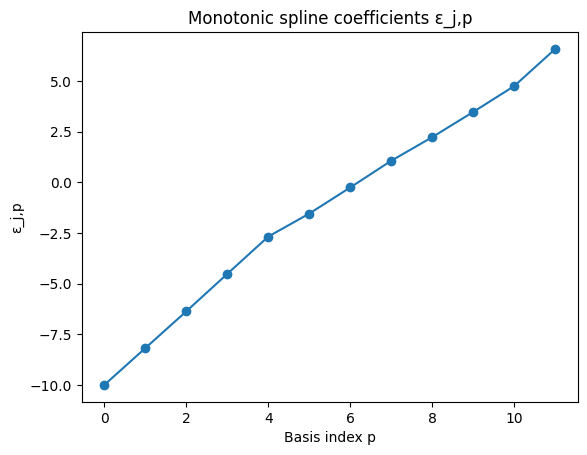

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.1508,  -8.4764,  -6.8011,  -5.1264,  -3.4550,  -1.8396,  -0.3617,
          0.9926,   2.2660,   3.5090,   4.6569,   7.4913])


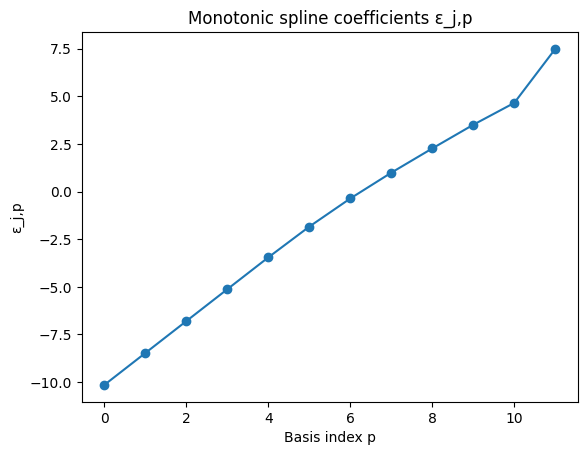

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.5879,  -9.1519,  -7.7159,  -6.2799,  -4.1222,  -0.7635,   3.1495,
          6.3175,   8.1358,   9.9539,  11.7721,  13.5903])


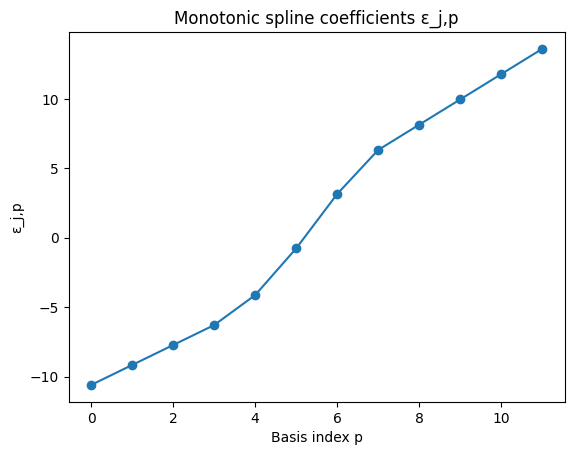

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0212,  -8.2624,  -6.5007,  -4.7401,  -2.9702,  -0.6475,   2.0900,
          4.8871,   6.7160,   8.5342,  10.3524,  12.1706])


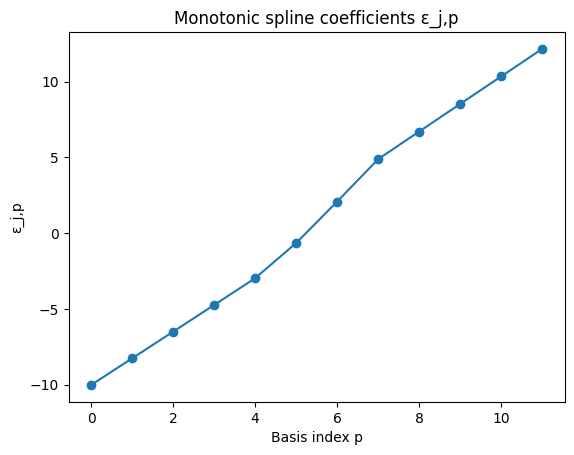

In [26]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

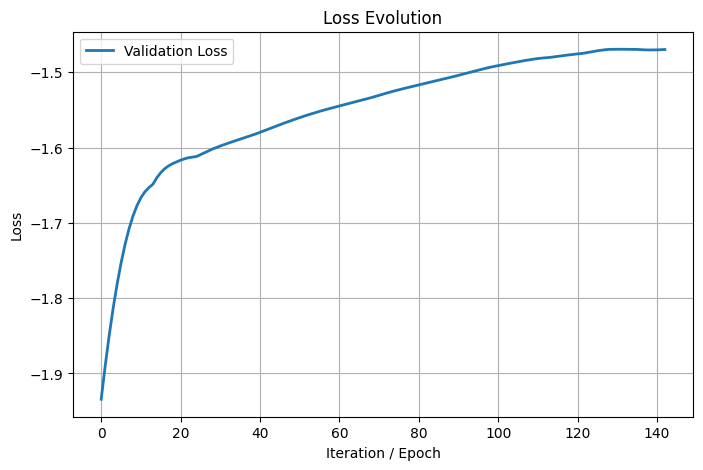

In [27]:
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [29]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [30]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.126
KLD GTM      Train Data:  -0.0019
KLD Gaussian Train Data:  -0.0014
KLD Copula   Train Data:  -0.0014

KLD BGTM      Test  Data:  0.1411
KLD GTM      Test  Data:  0.002
KLD Gaussian Test  Data:  0.0012
KLD Copula   Test  Data:  0.0012


In [31]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

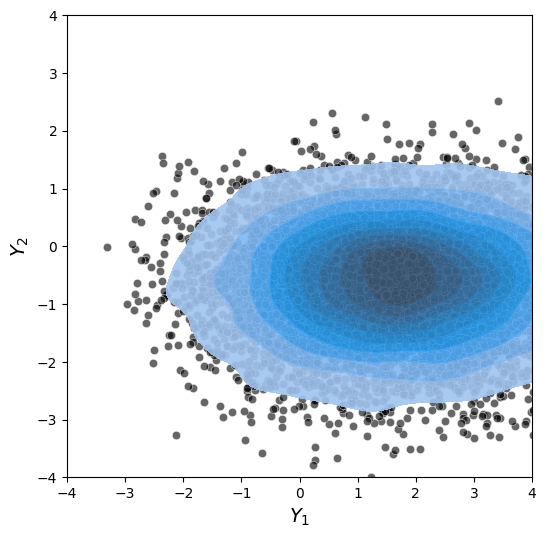

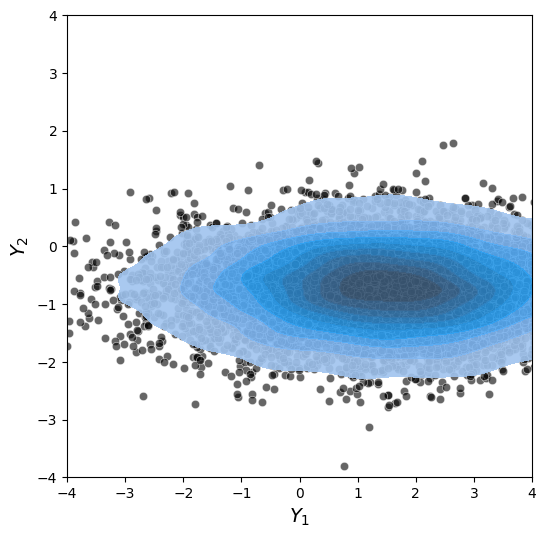

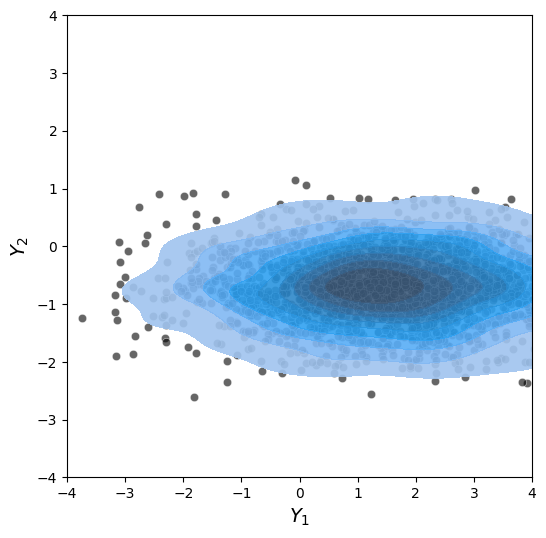

In [32]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [33]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [34]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

# BGTM

In [35]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


D = 24
First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:00<00:50,  3.94it/s]

ELPD change after μ-nudge: -159.46826171875
[1/200] train=41.5656  val_ELPD=-2.0325  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=1035.387508 rank=20  E_qf≈0.0448  tau*E[qf]≈46.36  Δ=-6.46e+01


  1%|          | 2/200 [00:00<00:46,  4.25it/s]

ELPD change after μ-nudge: -154.7021484375
[2/200] train=40.5099  val_ELPD=-2.0199  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=977.2362658 rank=20  E_qf≈0.0448  tau*E[qf]≈43.76  Δ=-5.82e+01


  2%|▏         | 3/200 [00:00<00:45,  4.35it/s]

ELPD change after μ-nudge: -149.8603515625
[3/200] train=41.5504  val_ELPD=-2.0110  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=924.9001476 rank=20  E_qf≈0.0448  tau*E[qf]≈41.41  Δ=-5.23e+01


  2%|▏         | 4/200 [00:00<00:44,  4.40it/s]

ELPD change after μ-nudge: -144.67919921875
[4/200] train=34.8586  val_ELPD=-2.0057  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=877.7976412 rank=20  E_qf≈0.0448  tau*E[qf]≈39.3  Δ=-4.71e+01


  2%|▎         | 5/200 [00:01<00:43,  4.44it/s]

ELPD change after μ-nudge: -138.78125
[5/200] train=39.7584  val_ELPD=-2.0027  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=835.4053854 rank=20  E_qf≈0.0448  tau*E[qf]≈37.41  Δ=-4.24e+01


  3%|▎         | 6/200 [00:01<00:43,  4.43it/s]

ELPD change after μ-nudge: -132.32177734375
[6/200] train=35.5802  val_ELPD=-2.0014  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=797.2523552 rank=20  E_qf≈0.0448  tau*E[qf]≈35.7  Δ=-3.82e+01


  4%|▎         | 7/200 [00:01<00:43,  4.44it/s]

ELPD change after μ-nudge: -125.859130859375
[7/200] train=37.8793  val_ELPD=-1.9956  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=762.914628 rank=20  E_qf≈0.0448  tau*E[qf]≈34.16  Δ=-3.43e+01


  4%|▍         | 8/200 [00:01<00:43,  4.46it/s]

ELPD change after μ-nudge: -119.606689453125
[8/200] train=36.6171  val_ELPD=-1.9905  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=732.0106735 rank=20  E_qf≈0.0448  tau*E[qf]≈32.78  Δ=-3.09e+01


  4%|▍         | 9/200 [00:02<00:44,  4.26it/s]

ELPD change after μ-nudge: -113.706298828125
[9/200] train=35.0492  val_ELPD=-1.9869  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=704.1971145 rank=20  E_qf≈0.0448  tau*E[qf]≈31.53  Δ=-2.78e+01


  5%|▌         | 10/200 [00:02<00:44,  4.32it/s]

ELPD change after μ-nudge: -107.811279296875
[10/200] train=35.5222  val_ELPD=-1.9841  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=679.1649114 rank=20  E_qf≈0.0448  tau*E[qf]≈30.41  Δ=-2.50e+01


  6%|▌         | 11/200 [00:02<00:46,  4.03it/s]

ELPD change after μ-nudge: -101.832275390625
[11/200] train=33.7234  val_ELPD=-1.9820  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=656.6359286 rank=20  E_qf≈0.0448  tau*E[qf]≈29.4  Δ=-2.25e+01


  6%|▌         | 12/200 [00:02<00:48,  3.87it/s]

ELPD change after μ-nudge: -96.166748046875
[12/200] train=36.4624  val_ELPD=-1.9806  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0631   tau4=636.3598441 rank=20  E_qf≈0.0448  tau*E[qf]≈28.49  Δ=-2.03e+01


  6%|▋         | 13/200 [00:03<00:49,  3.76it/s]

ELPD change after μ-nudge: -90.8408203125
[13/200] train=34.9562  val_ELPD=-1.9795  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=618.111368 rank=20  E_qf≈0.0448  tau*E[qf]≈27.68  Δ=-1.82e+01


  7%|▋         | 14/200 [00:03<00:50,  3.69it/s]

ELPD change after μ-nudge: -86.113037109375
[14/200] train=34.8468  val_ELPD=-1.9788  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=601.6877395 rank=20  E_qf≈0.0448  tau*E[qf]≈26.94  Δ=-1.64e+01


  8%|▊         | 15/200 [00:03<00:50,  3.65it/s]

ELPD change after μ-nudge: -83.009521484375
[15/200] train=32.4251  val_ELPD=-1.9771  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=586.9064739 rank=20  E_qf≈0.0448  tau*E[qf]≈26.28  Δ=-1.48e+01


  8%|▊         | 16/200 [00:03<00:50,  3.62it/s]

ELPD change after μ-nudge: -81.07470703125
[16/200] train=31.5937  val_ELPD=-1.9747  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=573.6033349 rank=20  E_qf≈0.0448  tau*E[qf]≈25.68  Δ=-1.33e+01


  8%|▊         | 17/200 [00:04<00:50,  3.60it/s]

ELPD change after μ-nudge: -79.867431640625
[17/200] train=34.0699  val_ELPD=-1.9722  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0695 σmin=0.0695 σmax=0.0696   tau4=561.6305097 rank=20  E_qf≈0.0448  tau*E[qf]≈25.15  Δ=-1.20e+01


  9%|▉         | 18/200 [00:04<00:50,  3.58it/s]

ELPD change after μ-nudge: -79.4892578125
[18/200] train=31.7237  val_ELPD=-1.9695  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=550.8549671 rank=20  E_qf≈0.0448  tau*E[qf]≈24.67  Δ=-1.08e+01


 10%|▉         | 19/200 [00:04<00:50,  3.57it/s]

ELPD change after μ-nudge: -79.6083984375
[19/200] train=31.3779  val_ELPD=-1.9668  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=541.1569787 rank=20  E_qf≈0.0448  tau*E[qf]≈24.23  Δ=-9.70e+00


 10%|█         | 20/200 [00:05<00:50,  3.57it/s]

ELPD change after μ-nudge: -80.3359375
[20/200] train=31.1943  val_ELPD=-1.9639  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=532.4287892 rank=20  E_qf≈0.0448  tau*E[qf]≈23.84  Δ=-8.73e+00


 10%|█         | 21/200 [00:05<00:56,  3.17it/s]

ELPD change after μ-nudge: -81.75048828125
[21/200] train=30.9236  val_ELPD=-1.9609  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=524.5734186 rank=20  E_qf≈0.0448  tau*E[qf]≈23.49  Δ=-7.86e+00


 11%|█         | 22/200 [00:05<01:00,  2.93it/s]

ELPD change after μ-nudge: -83.6572265625
[22/200] train=30.1563  val_ELPD=-1.9577  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=517.5035851 rank=20  E_qf≈0.0448  tau*E[qf]≈23.17  Δ=-7.07e+00


 12%|█▏        | 23/200 [00:06<01:03,  2.79it/s]

ELPD change after μ-nudge: -86.12939453125
[23/200] train=28.5339  val_ELPD=-1.9544  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0780 σmax=0.0781   tau4=511.1407349 rank=20  E_qf≈0.0448  tau*E[qf]≈22.89  Δ=-6.36e+00


 12%|█▏        | 24/200 [00:06<01:05,  2.69it/s]

ELPD change after μ-nudge: -89.106201171875
[24/200] train=30.2910  val_ELPD=-1.9510  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=505.4141697 rank=20  E_qf≈0.0448  tau*E[qf]≈22.63  Δ=-5.73e+00


 12%|█▎        | 25/200 [00:07<01:07,  2.60it/s]

ELPD change after μ-nudge: -92.375732421875
[25/200] train=29.0659  val_ELPD=-1.9477  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0811   tau4=500.2602611 rank=20  E_qf≈0.0448  tau*E[qf]≈22.4  Δ=-5.15e+00


 13%|█▎        | 26/200 [00:07<01:08,  2.55it/s]

ELPD change after μ-nudge: -96.266357421875
[26/200] train=27.7146  val_ELPD=-1.9443  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=495.6217433 rank=20  E_qf≈0.0448  tau*E[qf]≈22.19  Δ=-4.64e+00


 14%|█▎        | 27/200 [00:07<01:08,  2.53it/s]

ELPD change after μ-nudge: -100.31494140625
[27/200] train=28.7838  val_ELPD=-1.9411  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=491.4470773 rank=20  E_qf≈0.0448  tau*E[qf]≈22.01  Δ=-4.17e+00


 14%|█▍        | 28/200 [00:08<01:08,  2.52it/s]

ELPD change after μ-nudge: -104.5888671875
[28/200] train=27.9557  val_ELPD=-1.9380  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=487.6898779 rank=20  E_qf≈0.0448  tau*E[qf]≈21.84  Δ=-3.76e+00


 14%|█▍        | 29/200 [00:08<01:08,  2.51it/s]

ELPD change after μ-nudge: -108.9482421875
[29/200] train=26.8903  val_ELPD=-1.9351  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0875 σmin=0.0875 σmax=0.0876   tau4=484.3083985 rank=20  E_qf≈0.0448  tau*E[qf]≈21.69  Δ=-3.38e+00


 15%|█▌        | 30/200 [00:09<01:07,  2.51it/s]

ELPD change after μ-nudge: -113.40234375
[30/200] train=26.1648  val_ELPD=-1.9322  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0892   tau4=481.265067 rank=20  E_qf≈0.0448  tau*E[qf]≈21.55  Δ=-3.04e+00


 16%|█▌        | 31/200 [00:09<01:19,  2.12it/s]

ELPD change after μ-nudge: -117.546875
[31/200] train=25.5263  val_ELPD=-1.9289  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0909 σmin=0.0909 σmax=0.0910   tau4=478.5260686 rank=20  E_qf≈0.0448  tau*E[qf]≈21.43  Δ=-2.74e+00


 16%|█▌        | 32/200 [00:10<01:27,  1.92it/s]

ELPD change after μ-nudge: -121.475341796875
[32/200] train=25.4063  val_ELPD=-1.9256  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0927   tau4=476.0609701 rank=20  E_qf≈0.0448  tau*E[qf]≈21.32  Δ=-2.47e+00


 16%|█▋        | 33/200 [00:11<01:33,  1.79it/s]

ELPD change after μ-nudge: -125.399169921875
[33/200] train=24.6695  val_ELPD=-1.9223  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=473.8423814 rank=20  E_qf≈0.0448  tau*E[qf]≈21.22  Δ=-2.22e+00


 17%|█▋        | 34/200 [00:11<01:36,  1.71it/s]

ELPD change after μ-nudge: -129.072998046875
[34/200] train=24.7880  val_ELPD=-1.9191  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=471.8456516 rank=20  E_qf≈0.0448  tau*E[qf]≈21.13  Δ=-2.00e+00


 18%|█▊        | 35/200 [00:12<01:39,  1.66it/s]

ELPD change after μ-nudge: -132.539306640625
[35/200] train=24.6033  val_ELPD=-1.9162  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0981   tau4=470.0485948 rank=20  E_qf≈0.0448  tau*E[qf]≈21.05  Δ=-1.80e+00


 18%|█▊        | 36/200 [00:13<01:40,  1.63it/s]

ELPD change after μ-nudge: -135.5625
[36/200] train=23.7140  val_ELPD=-1.9133  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1000   tau4=468.4312436 rank=20  E_qf≈0.0448  tau*E[qf]≈20.97  Δ=-1.62e+00


 18%|█▊        | 37/200 [00:13<01:41,  1.61it/s]

ELPD change after μ-nudge: -138.270263671875
[37/200] train=22.9161  val_ELPD=-1.9105  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1019   tau4=466.9756276 rank=20  E_qf≈0.0448  tau*E[qf]≈20.91  Δ=-1.46e+00


 19%|█▉        | 38/200 [00:14<01:41,  1.59it/s]

ELPD change after μ-nudge: -140.56396484375
[38/200] train=22.6521  val_ELPD=-1.9077  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1038 σmin=0.1038 σmax=0.1038   tau4=465.6655732 rank=20  E_qf≈0.0448  tau*E[qf]≈20.85  Δ=-1.31e+00


 20%|█▉        | 39/200 [00:14<01:41,  1.58it/s]

ELPD change after μ-nudge: -142.65283203125
[39/200] train=22.5616  val_ELPD=-1.9050  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1058   tau4=464.4865242 rank=20  E_qf≈0.0448  tau*E[qf]≈20.8  Δ=-1.18e+00


 20%|██        | 40/200 [00:15<01:41,  1.57it/s]

ELPD change after μ-nudge: -144.329345703125
[40/200] train=22.0527  val_ELPD=-1.9023  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1078   tau4=463.4253801 rank=20  E_qf≈0.0448  tau*E[qf]≈20.75  Δ=-1.06e+00


 20%|██        | 41/200 [00:16<02:04,  1.28it/s]

ELPD change after μ-nudge: -145.920166015625
[41/200] train=21.5411  val_ELPD=-1.8998  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1099   tau4=462.4703504 rank=20  E_qf≈0.0448  tau*E[qf]≈20.71  Δ=-9.55e-01


 21%|██        | 42/200 [00:18<02:30,  1.05it/s]

ELPD change after μ-nudge: -147.265625
[42/200] train=21.2929  val_ELPD=-1.8973  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1119 σmin=0.1119 σmax=0.1120   tau4=461.6108237 rank=20  E_qf≈0.0448  tau*E[qf]≈20.67  Δ=-8.60e-01


 22%|██▏       | 43/200 [00:19<02:37,  1.00s/it]

ELPD change after μ-nudge: -148.67822265625
[43/200] train=20.6544  val_ELPD=-1.8950  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1141   tau4=460.8372497 rank=20  E_qf≈0.0448  tau*E[qf]≈20.63  Δ=-7.74e-01


 22%|██▏       | 44/200 [00:20<02:49,  1.09s/it]

ELPD change after μ-nudge: -149.753173828125
[44/200] train=20.3176  val_ELPD=-1.8927  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1162   tau4=460.1410331 rank=20  E_qf≈0.0448  tau*E[qf]≈20.6  Δ=-6.96e-01


 22%|██▎       | 45/200 [00:21<02:50,  1.10s/it]

ELPD change after μ-nudge: -150.91796875
[45/200] train=19.4876  val_ELPD=-1.8907  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1184 σmax=0.1184   tau4=459.5144381 rank=20  E_qf≈0.0448  tau*E[qf]≈20.58  Δ=-6.27e-01


 23%|██▎       | 46/200 [00:22<02:51,  1.11s/it]

ELPD change after μ-nudge: -152.35205078125
[46/200] train=19.5972  val_ELPD=-1.8890  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1206 σmin=0.1206 σmax=0.1206   tau4=458.9505026 rank=20  E_qf≈0.0448  tau*E[qf]≈20.55  Δ=-5.64e-01


 24%|██▎       | 47/200 [00:23<02:51,  1.12s/it]

ELPD change after μ-nudge: -153.693359375
[47/200] train=18.2376  val_ELPD=-1.8875  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1228 σmax=0.1229   tau4=458.4429607 rank=20  E_qf≈0.0448  tau*E[qf]≈20.53  Δ=-5.08e-01


 24%|██▍       | 48/200 [00:24<02:50,  1.12s/it]

ELPD change after μ-nudge: -154.889892578125
[48/200] train=18.9405  val_ELPD=-1.8864  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1251 σmax=0.1252   tau4=457.986173 rank=20  E_qf≈0.0448  tau*E[qf]≈20.51  Δ=-4.57e-01


 24%|██▍       | 49/200 [00:26<02:50,  1.13s/it]

ELPD change after μ-nudge: -155.93017578125
[49/200] train=17.8416  val_ELPD=-1.8848  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1275 σmin=0.1275 σmax=0.1276   tau4=457.575064 rank=20  E_qf≈0.0448  tau*E[qf]≈20.49  Δ=-4.11e-01


 25%|██▌       | 50/200 [00:27<02:50,  1.14s/it]

ELPD change after μ-nudge: -156.751220703125
[50/200] train=17.4816  val_ELPD=-1.8820  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1299 σmin=0.1299 σmax=0.1300   tau4=457.2050659 rank=20  E_qf≈0.0448  tau*E[qf]≈20.47  Δ=-3.70e-01


 26%|██▌       | 51/200 [00:28<02:49,  1.14s/it]

ELPD change after μ-nudge: -156.71240234375
[51/200] train=17.0470  val_ELPD=-1.8790  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1323 σmin=0.1323 σmax=0.1324   tau4=456.8720677 rank=20  E_qf≈0.0448  tau*E[qf]≈20.46  Δ=-3.33e-01


 26%|██▌       | 52/200 [00:29<02:54,  1.18s/it]

ELPD change after μ-nudge: -156.88427734375
[52/200] train=16.5906  val_ELPD=-1.8762  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1348 σmin=0.1347 σmax=0.1348   tau4=456.5723692 rank=20  E_qf≈0.0448  tau*E[qf]≈20.44  Δ=-3.00e-01


 26%|██▋       | 53/200 [00:30<02:51,  1.17s/it]

ELPD change after μ-nudge: -156.6318359375
[53/200] train=15.6926  val_ELPD=-1.8734  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1373 σmin=0.1372 σmax=0.1374   tau4=456.3026407 rank=20  E_qf≈0.0448  tau*E[qf]≈20.43  Δ=-2.70e-01


 27%|██▋       | 54/200 [00:31<02:48,  1.16s/it]

ELPD change after μ-nudge: -156.22509765625
[54/200] train=15.4906  val_ELPD=-1.8708  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1399 σmin=0.1398 σmax=0.1399   tau4=456.0598849 rank=20  E_qf≈0.0448  tau*E[qf]≈20.42  Δ=-2.43e-01


 28%|██▊       | 55/200 [00:33<02:46,  1.15s/it]

ELPD change after μ-nudge: -156.312255859375
[55/200] train=15.7805  val_ELPD=-1.8684  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1424 σmin=0.1424 σmax=0.1425   tau4=455.8414048 rank=20  E_qf≈0.0448  tau*E[qf]≈20.41  Δ=-2.18e-01


 28%|██▊       | 56/200 [00:34<02:45,  1.15s/it]

ELPD change after μ-nudge: -156.678955078125
[56/200] train=14.6874  val_ELPD=-1.8660  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1451 σmin=0.1450 σmax=0.1451   tau4=455.6447726 rank=20  E_qf≈0.0448  tau*E[qf]≈20.4  Δ=-1.97e-01


 28%|██▊       | 57/200 [00:35<02:44,  1.15s/it]

ELPD change after μ-nudge: -157.424072265625
[57/200] train=14.7631  val_ELPD=-1.8637  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1478 σmin=0.1477 σmax=0.1478   tau4=455.4678037 rank=20  E_qf≈0.0448  tau*E[qf]≈20.39  Δ=-1.77e-01


 29%|██▉       | 58/200 [00:36<02:43,  1.15s/it]

ELPD change after μ-nudge: -157.73828125
[58/200] train=13.5525  val_ELPD=-1.8616  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1505 σmin=0.1504 σmax=0.1505   tau4=455.3085317 rank=20  E_qf≈0.0448  tau*E[qf]≈20.39  Δ=-1.59e-01


 30%|██▉       | 59/200 [00:37<02:42,  1.15s/it]

ELPD change after μ-nudge: -157.779541015625
[59/200] train=13.6019  val_ELPD=-1.8596  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1532 σmin=0.1531 σmax=0.1533   tau4=455.1651868 rank=20  E_qf≈0.0448  tau*E[qf]≈20.38  Δ=-1.43e-01


 30%|███       | 60/200 [00:38<02:40,  1.15s/it]

ELPD change after μ-nudge: -158.7080078125
[60/200] train=13.3702  val_ELPD=-1.8576  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1560 σmin=0.1559 σmax=0.1561   tau4=455.0361765 rank=20  E_qf≈0.0448  tau*E[qf]≈20.38  Δ=-1.29e-01


 30%|███       | 61/200 [00:40<02:41,  1.16s/it]

ELPD change after μ-nudge: -161.053955078125
[61/200] train=12.6648  val_ELPD=-1.8554  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1589 σmin=0.1588 σmax=0.1590   tau4=454.9200672 rank=20  E_qf≈0.0448  tau*E[qf]≈20.37  Δ=-1.16e-01


 31%|███       | 62/200 [00:41<02:39,  1.16s/it]

ELPD change after μ-nudge: -163.910400390625
[62/200] train=12.7867  val_ELPD=-1.8535  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1618 σmin=0.1617 σmax=0.1619   tau4=454.8155688 rank=20  E_qf≈0.0448  tau*E[qf]≈20.37  Δ=-1.04e-01


 32%|███▏      | 63/200 [00:42<02:37,  1.15s/it]

ELPD change after μ-nudge: -167.021484375
[63/200] train=11.8128  val_ELPD=-1.8515  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1647 σmin=0.1646 σmax=0.1648   tau4=454.7215202 rank=20  E_qf≈0.0448  tau*E[qf]≈20.36  Δ=-9.40e-02


 32%|███▏      | 64/200 [00:43<02:37,  1.16s/it]

ELPD change after μ-nudge: -170.06103515625
[64/200] train=10.8328  val_ELPD=-1.8496  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1677 σmin=0.1676 σmax=0.1678   tau4=454.6368766 rank=20  E_qf≈0.0448  tau*E[qf]≈20.36  Δ=-8.46e-02


 32%|███▎      | 65/200 [00:44<02:35,  1.15s/it]

ELPD change after μ-nudge: -173.49658203125
[65/200] train=10.5013  val_ELPD=-1.8478  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1708 σmin=0.1706 σmax=0.1709   tau4=454.5606972 rank=20  E_qf≈0.0448  tau*E[qf]≈20.35  Δ=-7.62e-02


 33%|███▎      | 66/200 [00:45<02:33,  1.14s/it]

ELPD change after μ-nudge: -176.937744140625
[66/200] train=10.7870  val_ELPD=-1.8461  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1739 σmin=0.1737 σmax=0.1740   tau4=454.4921358 rank=20  E_qf≈0.0448  tau*E[qf]≈20.35  Δ=-6.86e-02


 34%|███▎      | 67/200 [00:46<02:31,  1.14s/it]

ELPD change after μ-nudge: -180.670166015625
[67/200] train=10.1673  val_ELPD=-1.8443  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1770 σmin=0.1768 σmax=0.1771   tau4=454.4304306 rank=20  E_qf≈0.0448  tau*E[qf]≈20.35  Δ=-6.17e-02


 34%|███▍      | 68/200 [00:48<02:31,  1.15s/it]

ELPD change after μ-nudge: -184.5654296875
[68/200] train=9.0406  val_ELPD=-1.8425  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1802 σmin=0.1800 σmax=0.1803   tau4=454.3748959 rank=20  E_qf≈0.0448  tau*E[qf]≈20.35  Δ=-5.55e-02


 34%|███▍      | 69/200 [00:49<02:29,  1.14s/it]

ELPD change after μ-nudge: -187.4228515625
[69/200] train=9.8185  val_ELPD=-1.8409  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1834 σmin=0.1832 σmax=0.1835   tau4=454.3249146 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-5.00e-02


 35%|███▌      | 70/200 [00:50<02:28,  1.14s/it]

ELPD change after μ-nudge: -192.1201171875
[70/200] train=8.4665  val_ELPD=-1.8390  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1867 σmin=0.1864 σmax=0.1868   tau4=454.2799315 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-4.50e-02


 36%|███▌      | 71/200 [00:51<02:26,  1.14s/it]

ELPD change after μ-nudge: -198.88916015625
[71/200] train=8.1424  val_ELPD=-1.8369  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1900 σmin=0.1898 σmax=0.1902   tau4=454.2394467 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-4.05e-02


 36%|███▌      | 72/200 [00:52<02:25,  1.14s/it]

ELPD change after μ-nudge: -206.231689453125
[72/200] train=7.6117  val_ELPD=-1.8350  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1934 σmin=0.1931 σmax=0.1936   tau4=454.2030103 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-3.64e-02


 36%|███▋      | 73/200 [00:53<02:24,  1.14s/it]

ELPD change after μ-nudge: -212.08837890625
[73/200] train=8.2210  val_ELPD=-1.8333  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1968 σmin=0.1965 σmax=0.1970   tau4=454.1702176 rank=20  E_qf≈0.0448  tau*E[qf]≈20.34  Δ=-3.28e-02


 37%|███▋      | 74/200 [00:54<02:23,  1.14s/it]

ELPD change after μ-nudge: -218.141845703125
[74/200] train=7.7609  val_ELPD=-1.8318  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2003 σmin=0.2000 σmax=0.2005   tau4=454.1407042 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-2.95e-02


 38%|███▊      | 75/200 [00:56<02:21,  1.13s/it]

ELPD change after μ-nudge: -222.812744140625
[75/200] train=6.1261  val_ELPD=-1.8305  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2039 σmin=0.2035 σmax=0.2041   tau4=454.1141421 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-2.66e-02


 38%|███▊      | 76/200 [00:57<02:20,  1.13s/it]

ELPD change after μ-nudge: -225.2431640625
[76/200] train=5.8895  val_ELPD=-1.8290  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2074 σmin=0.2070 σmax=0.2077   tau4=454.0902363 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-2.39e-02


 38%|███▊      | 77/200 [00:58<02:19,  1.14s/it]

ELPD change after μ-nudge: -227.271484375
[77/200] train=6.3515  val_ELPD=-1.8278  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2111 σmin=0.2107 σmax=0.2113   tau4=454.068721 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-2.15e-02


 39%|███▉      | 78/200 [00:59<02:18,  1.13s/it]

ELPD change after μ-nudge: -228.4619140625
[78/200] train=5.0772  val_ELPD=-1.8266  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2148 σmin=0.2143 σmax=0.2150   tau4=454.0493572 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.94e-02


 40%|███▉      | 79/200 [01:00<02:18,  1.14s/it]

ELPD change after μ-nudge: -227.641845703125
[79/200] train=5.2084  val_ELPD=-1.8255  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2185 σmin=0.2180 σmax=0.2188   tau4=454.0319298 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.74e-02


 40%|████      | 80/200 [01:01<02:17,  1.14s/it]

ELPD change after μ-nudge: -227.728759765625
[80/200] train=4.7483  val_ELPD=-1.8244  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2223 σmin=0.2218 σmax=0.2226   tau4=454.0162452 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.57e-02


 40%|████      | 81/200 [01:02<02:15,  1.14s/it]

ELPD change after μ-nudge: -226.49951171875
[81/200] train=4.1485  val_ELPD=-1.8233  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2262 σmin=0.2256 σmax=0.2265   tau4=454.002129 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.41e-02


 41%|████      | 82/200 [01:03<02:14,  1.14s/it]

ELPD change after μ-nudge: -226.18896484375
[82/200] train=3.3326  val_ELPD=-1.8224  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2301 σmin=0.2295 σmax=0.2305   tau4=453.9894244 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.27e-02


 42%|████▏     | 83/200 [01:05<02:13,  1.14s/it]

ELPD change after μ-nudge: -226.5654296875
[83/200] train=3.4516  val_ELPD=-1.8212  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2341 σmin=0.2335 σmax=0.2344   tau4=453.9779903 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.14e-02


 42%|████▏     | 84/200 [01:06<02:12,  1.14s/it]

ELPD change after μ-nudge: -229.573486328125
[84/200] train=2.2517  val_ELPD=-1.8195  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2381 σmin=0.2375 σmax=0.2385   tau4=453.9676996 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-1.03e-02


 42%|████▎     | 85/200 [01:07<02:11,  1.15s/it]

ELPD change after μ-nudge: -234.893310546875
[85/200] train=2.6415  val_ELPD=-1.8174  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2422 σmin=0.2415 σmax=0.2426   tau4=453.958438 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-9.26e-03


 43%|████▎     | 86/200 [01:08<02:10,  1.14s/it]

ELPD change after μ-nudge: -241.59228515625
[86/200] train=2.4372  val_ELPD=-1.8150  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2463 σmin=0.2456 σmax=0.2468   tau4=453.9501025 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-8.34e-03


 44%|████▎     | 87/200 [01:09<02:08,  1.14s/it]

ELPD change after μ-nudge: -246.939697265625
[87/200] train=1.1775  val_ELPD=-1.8127  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2505 σmin=0.2498 σmax=0.2510   tau4=453.9426006 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-7.50e-03


 44%|████▍     | 88/200 [01:10<02:07,  1.14s/it]

ELPD change after μ-nudge: -251.646240234375
[88/200] train=1.2135  val_ELPD=-1.8108  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2548 σmin=0.2540 σmax=0.2553   tau4=453.9358489 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-6.75e-03


 44%|████▍     | 89/200 [01:11<02:06,  1.14s/it]

ELPD change after μ-nudge: -258.540283203125
[89/200] train=0.6558  val_ELPD=-1.8086  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2591 σmin=0.2583 σmax=0.2596   tau4=453.9297723 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-6.08e-03


 45%|████▌     | 90/200 [01:13<02:05,  1.14s/it]

ELPD change after μ-nudge: -270.350341796875
[90/200] train=-0.0524  val_ELPD=-1.8064  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2634 σmin=0.2626 σmax=0.2640   tau4=453.9243034 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-5.47e-03


 46%|████▌     | 91/200 [01:14<02:03,  1.14s/it]

ELPD change after μ-nudge: -280.8388671875
[91/200] train=-0.0340  val_ELPD=-1.8042  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2678 σmin=0.2669 σmax=0.2685   tau4=453.9193814 rank=20  E_qf≈0.0448  tau*E[qf]≈20.33  Δ=-4.92e-03


 46%|████▌     | 92/200 [01:15<02:02,  1.14s/it]

ELPD change after μ-nudge: -288.798828125
[92/200] train=-0.0756  val_ELPD=-1.8022  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2723 σmin=0.2714 σmax=0.2730   tau4=453.9149516 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.43e-03


 46%|████▋     | 93/200 [01:16<02:07,  1.19s/it]

ELPD change after μ-nudge: -295.583251953125
[93/200] train=-0.6690  val_ELPD=-1.8003  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2769 σmin=0.2758 σmax=0.2776   tau4=453.9109648 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.99e-03


 47%|████▋     | 94/200 [01:17<02:04,  1.17s/it]

ELPD change after μ-nudge: -303.1943359375
[94/200] train=-1.7087  val_ELPD=-1.7983  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2815 σmin=0.2804 σmax=0.2822   tau4=453.9073766 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.59e-03


 48%|████▊     | 95/200 [01:18<02:02,  1.17s/it]

ELPD change after μ-nudge: -311.94580078125
[95/200] train=-1.5895  val_ELPD=-1.7961  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2861 σmin=0.2849 σmax=0.2869   tau4=453.9041473 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.23e-03


 48%|████▊     | 96/200 [01:20<02:00,  1.16s/it]

ELPD change after μ-nudge: -321.259521484375
[96/200] train=-1.9832  val_ELPD=-1.7942  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2908 σmin=0.2896 σmax=0.2917   tau4=453.9012409 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.91e-03


 48%|████▊     | 97/200 [01:21<01:58,  1.15s/it]

ELPD change after μ-nudge: -332.501220703125
[97/200] train=-2.6327  val_ELPD=-1.7924  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2956 σmin=0.2943 σmax=0.2965   tau4=453.8986252 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.62e-03


 49%|████▉     | 98/200 [01:22<01:56,  1.15s/it]

ELPD change after μ-nudge: -344.343994140625
[98/200] train=-2.2599  val_ELPD=-1.7909  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3004 σmin=0.2990 σmax=0.3014   tau4=453.896271 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.35e-03


 50%|████▉     | 99/200 [01:23<01:55,  1.14s/it]

ELPD change after μ-nudge: -359.540771484375
[99/200] train=-3.5947  val_ELPD=-1.7899  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3053 σmin=0.3038 σmax=0.3063   tau4=453.8941522 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.12e-03


 50%|█████     | 100/200 [01:24<01:54,  1.14s/it]

ELPD change after μ-nudge: -370.502197265625
[100/200] train=-3.8249  val_ELPD=-1.7890  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3103 σmin=0.3087 σmax=0.3113   tau4=453.8922453 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.91e-03


 50%|█████     | 101/200 [01:25<01:52,  1.14s/it]

ELPD change after μ-nudge: -373.885986328125
[101/200] train=-3.8578  val_ELPD=-1.7879  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3153 σmin=0.3137 σmax=0.3164   tau4=453.8905291 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.72e-03


 51%|█████     | 102/200 [01:26<01:52,  1.14s/it]

ELPD change after μ-nudge: -376.226318359375
[102/200] train=-4.0056  val_ELPD=-1.7869  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3204 σmin=0.3187 σmax=0.3215   tau4=453.8889846 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.54e-03


 52%|█████▏    | 103/200 [01:28<01:53,  1.17s/it]

ELPD change after μ-nudge: -375.1806640625
[103/200] train=-4.4653  val_ELPD=-1.7864  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3255 σmin=0.3237 σmax=0.3267   tau4=453.8875944 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.39e-03


 52%|█████▏    | 104/200 [01:29<01:54,  1.19s/it]

ELPD change after μ-nudge: -369.473388671875
[104/200] train=-4.7930  val_ELPD=-1.7864  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3307 σmin=0.3288 σmax=0.3320   tau4=453.8863433 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.25e-03


 52%|█████▎    | 105/200 [01:30<01:52,  1.18s/it]

ELPD change after μ-nudge: -362.240478515625
[105/200] train=-5.1503  val_ELPD=-1.7868  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3360 σmin=0.3340 σmax=0.3373   tau4=453.8852173 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.13e-03


 53%|█████▎    | 106/200 [01:31<01:50,  1.18s/it]

ELPD change after μ-nudge: -363.266357421875
[106/200] train=-5.9816  val_ELPD=-1.7867  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3413 σmin=0.3392 σmax=0.3427   tau4=453.8842039 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.01e-03


 54%|█████▎    | 107/200 [01:32<01:48,  1.17s/it]

ELPD change after μ-nudge: -361.843017578125
[107/200] train=-6.3478  val_ELPD=-1.7871  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3467 σmin=0.3444 σmax=0.3482   tau4=453.8832919 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-9.12e-04


 54%|█████▍    | 108/200 [01:34<01:46,  1.16s/it]

ELPD change after μ-nudge: -362.51123046875
[108/200] train=-6.8230  val_ELPD=-1.7871  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3521 σmin=0.3497 σmax=0.3537   tau4=453.882471 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-8.21e-04


 55%|█████▍    | 109/200 [01:35<01:45,  1.16s/it]

ELPD change after μ-nudge: -361.998291015625
[109/200] train=-6.7068  val_ELPD=-1.7874  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3576 σmin=0.3551 σmax=0.3593   tau4=453.8817323 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-7.39e-04


 55%|█████▌    | 110/200 [01:36<01:44,  1.16s/it]

ELPD change after μ-nudge: -369.861083984375
[110/200] train=-6.7525  val_ELPD=-1.7866  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3631 σmin=0.3605 σmax=0.3649   tau4=453.8810674 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-6.65e-04


 56%|█████▌    | 111/200 [01:37<01:42,  1.15s/it]

ELPD change after μ-nudge: -372.953857421875
[111/200] train=-6.9460  val_ELPD=-1.7861  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3659 σmin=0.3632 σmax=0.3678   tau4=453.880469 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-5.98e-04


 56%|█████▌    | 112/200 [01:38<01:41,  1.15s/it]

ELPD change after μ-nudge: -373.7724609375
[112/200] train=-7.8103  val_ELPD=-1.7862  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3687 σmin=0.3660 σmax=0.3706   tau4=453.8799304 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-5.39e-04


 56%|█████▋    | 113/200 [01:39<01:39,  1.15s/it]

ELPD change after μ-nudge: -375.316650390625
[113/200] train=-7.9134  val_ELPD=-1.7861  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3716 σmin=0.3687 σmax=0.3735   tau4=453.8794457 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.85e-04


 57%|█████▋    | 114/200 [01:40<01:38,  1.14s/it]

ELPD change after μ-nudge: -378.544677734375
[114/200] train=-7.9907  val_ELPD=-1.7855  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3744 σmin=0.3714 σmax=0.3764   tau4=453.8790095 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.36e-04


 57%|█████▊    | 115/200 [01:42<01:37,  1.14s/it]

ELPD change after μ-nudge: -386.660888671875
[115/200] train=-8.9211  val_ELPD=-1.7845  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3772 σmin=0.3742 σmax=0.3793   tau4=453.8786169 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.93e-04


 58%|█████▊    | 116/200 [01:43<01:35,  1.14s/it]

ELPD change after μ-nudge: -395.279052734375
[116/200] train=-8.1613  val_ELPD=-1.7836  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3801 σmin=0.3770 σmax=0.3822   tau4=453.8782635 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.53e-04


 58%|█████▊    | 117/200 [01:44<01:34,  1.14s/it]

ELPD change after μ-nudge: -403.6328125
[117/200] train=-7.7780  val_ELPD=-1.7824  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3830 σmin=0.3798 σmax=0.3852   tau4=453.8779455 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.18e-04


 59%|█████▉    | 118/200 [01:45<01:33,  1.14s/it]

ELPD change after μ-nudge: -412.01904296875
[118/200] train=-9.2055  val_ELPD=-1.7815  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3859 σmin=0.3825 σmax=0.3881   tau4=453.8776593 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.86e-04


 60%|█████▉    | 119/200 [01:46<01:32,  1.14s/it]

ELPD change after μ-nudge: -420.186279296875
[119/200] train=-9.0081  val_ELPD=-1.7807  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3888 σmin=0.3854 σmax=0.3911   tau4=453.8774017 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.58e-04


 60%|██████    | 120/200 [01:47<01:31,  1.14s/it]

ELPD change after μ-nudge: -427.126708984375
[120/200] train=-9.1117  val_ELPD=-1.7801  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3917 σmin=0.3882 σmax=0.3940   tau4=453.8771698 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.32e-04


 60%|██████    | 121/200 [01:48<01:30,  1.14s/it]

ELPD change after μ-nudge: -435.1455078125
[121/200] train=-9.5239  val_ELPD=-1.7793  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3946 σmin=0.3910 σmax=0.3970   tau4=453.8769612 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.09e-04


 61%|██████    | 122/200 [01:50<01:29,  1.14s/it]

ELPD change after μ-nudge: -439.56884765625
[122/200] train=-8.7241  val_ELPD=-1.7789  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.3976 σmin=0.3938 σmax=0.4001   tau4=453.8767734 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.88e-04


 62%|██████▏   | 123/200 [01:51<01:27,  1.14s/it]

ELPD change after μ-nudge: -448.84228515625
[123/200] train=-9.8596  val_ELPD=-1.7784  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4005 σmin=0.3967 σmax=0.4031   tau4=453.8766044 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.69e-04


 62%|██████▏   | 124/200 [01:52<01:26,  1.14s/it]

ELPD change after μ-nudge: -460.644287109375
[124/200] train=-10.1896  val_ELPD=-1.7779  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4035 σmin=0.3996 σmax=0.4061   tau4=453.8764523 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.52e-04


 62%|██████▎   | 125/200 [01:53<01:25,  1.14s/it]

ELPD change after μ-nudge: -470.1708984375
[125/200] train=-9.5099  val_ELPD=-1.7774  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4065 σmin=0.4024 σmax=0.4092   tau4=453.8763154 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.37e-04


 63%|██████▎   | 126/200 [01:54<01:24,  1.14s/it]

ELPD change after μ-nudge: -483.678955078125
[126/200] train=-9.2554  val_ELPD=-1.7768  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4095 σmin=0.4053 σmax=0.4123   tau4=453.8761922 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.23e-04


 64%|██████▎   | 127/200 [01:55<01:23,  1.14s/it]

ELPD change after μ-nudge: -496.625732421875
[127/200] train=-10.2384  val_ELPD=-1.7769  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4125 σmin=0.4082 σmax=0.4154   tau4=453.8760813 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-1.11e-04


 64%|██████▍   | 128/200 [01:56<01:22,  1.14s/it]

ELPD change after μ-nudge: -510.99462890625
[128/200] train=-10.7303  val_ELPD=-1.7771  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4156 σmin=0.4111 σmax=0.4185   tau4=453.8759815 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-9.98e-05


 64%|██████▍   | 129/200 [01:58<01:21,  1.14s/it]

ELPD change after μ-nudge: -525.62841796875
[129/200] train=-10.6212  val_ELPD=-1.7775  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4186 σmin=0.4140 σmax=0.4216   tau4=453.8758917 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-8.98e-05


 65%|██████▌   | 130/200 [01:59<01:20,  1.15s/it]

ELPD change after μ-nudge: -536.046630859375
[130/200] train=-11.1378  val_ELPD=-1.7784  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4217 σmin=0.4170 σmax=0.4247   tau4=453.8758109 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-8.08e-05


 66%|██████▌   | 131/200 [02:00<01:18,  1.14s/it]

ELPD change after μ-nudge: -542.7861328125
[131/200] train=-10.4247  val_ELPD=-1.7792  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4248 σmin=0.4199 σmax=0.4279   tau4=453.8757381 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-7.28e-05


 66%|██████▌   | 132/200 [02:01<01:17,  1.14s/it]

ELPD change after μ-nudge: -549.293701171875
[132/200] train=-11.5050  val_ELPD=-1.7802  S_train=64 S_val=16 lr=[0.005, 0.01] σ̄=0.4278 σmin=0.4229 σmax=0.4311   tau4=453.8756726 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-6.55e-05


 66%|██████▋   | 133/200 [02:02<01:16,  1.14s/it]

ELPD change after μ-nudge: -555.0625
[133/200] train=-11.4904  val_ELPD=-1.7812  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4310 σmin=0.4259 σmax=0.4343   tau4=453.8756137 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-5.89e-05


 67%|██████▋   | 134/200 [02:03<01:15,  1.14s/it]

ELPD change after μ-nudge: -556.420654296875
[134/200] train=-11.5531  val_ELPD=-1.7815  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4325 σmin=0.4274 σmax=0.4359   tau4=453.8755607 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-5.30e-05


 68%|██████▊   | 135/200 [02:04<01:14,  1.14s/it]

ELPD change after μ-nudge: -555.914794921875
[135/200] train=-11.8251  val_ELPD=-1.7819  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4341 σmin=0.4289 σmax=0.4375   tau4=453.8755129 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.77e-05


 68%|██████▊   | 136/200 [02:06<01:13,  1.14s/it]

ELPD change after μ-nudge: -553.158203125
[136/200] train=-11.8027  val_ELPD=-1.7822  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4357 σmin=0.4304 σmax=0.4391   tau4=453.87547 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-4.30e-05


 68%|██████▊   | 137/200 [02:07<01:11,  1.14s/it]

ELPD change after μ-nudge: -549.890380859375
[137/200] train=-11.1367  val_ELPD=-1.7826  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4372 σmin=0.4319 σmax=0.4407   tau4=453.8754313 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.87e-05


 69%|██████▉   | 138/200 [02:08<01:10,  1.14s/it]

ELPD change after μ-nudge: -548.554931640625
[138/200] train=-11.5188  val_ELPD=-1.7830  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4388 σmin=0.4334 σmax=0.4423   tau4=453.8753965 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.48e-05


 70%|██████▉   | 139/200 [02:09<01:09,  1.14s/it]

ELPD change after μ-nudge: -547.307373046875
[139/200] train=-11.7859  val_ELPD=-1.7833  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4404 σmin=0.4349 σmax=0.4439   tau4=453.8753652 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-3.13e-05


 70%|███████   | 140/200 [02:10<01:08,  1.14s/it]

ELPD change after μ-nudge: -546.812255859375
[140/200] train=-12.3036  val_ELPD=-1.7834  S_train=64 S_val=16 lr=[0.0025, 0.005] σ̄=0.4420 σmin=0.4364 σmax=0.4456   tau4=453.875337 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.82e-05


 70%|███████   | 140/200 [02:11<00:56,  1.06it/s]

ELPD change after μ-nudge: -546.031982421875
[141/200] train=-12.1597  val_ELPD=-1.7836  S_train=64 S_val=16 lr=[0.00125, 0.0025] σ̄=0.4435 σmin=0.4379 σmax=0.4472   tau4=453.8753117 rank=20  E_qf≈0.0448  tau*E[qf]≈20.32  Δ=-2.54e-05
Early stop @ epoch 141: no val improvement for 15 epochs.


# GTM

In [36]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 3/1000 [00:00<00:33, 29.47it/s]

current_loss: tensor(2.1378, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0107, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8794, grad_fn=<MeanBackward0>)
current_loss: tensor(2.2187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7375, grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<00:29, 33.48it/s]

current_loss: tensor(1.7375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7011, grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:00<00:38, 25.39it/s]

current_loss: tensor(1.7011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:00<00:36, 26.85it/s]

current_loss: tensor(1.9741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:01<00:30, 31.58it/s]

current_loss: tensor(1.6585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:28, 34.30it/s]

current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6459, grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:01<00:29, 32.04it/s]

current_loss: tensor(1.6459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6427, grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:01<00:27, 34.63it/s]

current_loss: tensor(1.6427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:01<00:27, 33.95it/s]

current_loss: tensor(1.6416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6404, grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:02<00:27, 33.64it/s]

current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:02<00:26, 35.25it/s]

current_loss: tensor(1.6402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:02<00:24, 36.71it/s]

current_loss: tensor(1.6401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:02<00:24, 36.75it/s]

current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:02<00:24, 37.20it/s]

current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6392, grad_fn=<MeanBackward0>)


 11%|█         | 107/1000 [00:03<00:25, 35.03it/s]

current_loss: tensor(1.6392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)


 12%|█▏        | 115/1000 [00:03<00:24, 36.32it/s]

current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:03<00:23, 36.64it/s]

current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)


 13%|█▎        | 131/1000 [00:03<00:24, 35.85it/s]

current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391,

 14%|█▎        | 136/1000 [00:04<00:26, 32.12it/s]

current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6391, grad_fn=<MeanBackward0>)
Early Stop at iteration 136 with minimal loss tensor(1.6391, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.6748,  -9.3959,  -8.1171,  -6.8597,  -1.4677,  -0.4522,  -0.4521,
          1.4075,   9.9253,  11.7310,  13.5492,  15.3674])


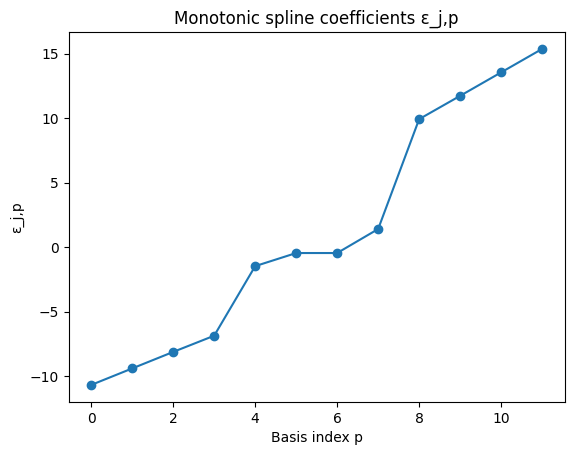

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8869, -8.0034, -6.1188, -4.2344, -2.3557, -1.0824,  0.0207,  1.4764,
         4.4830,  7.2642,  9.0824, 10.9006])


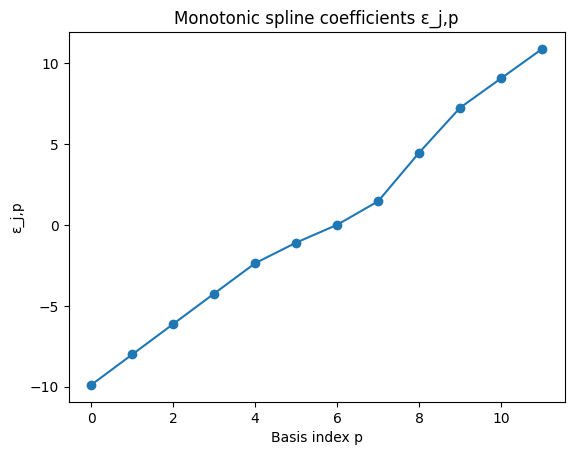

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9582, -8.1233, -6.2884, -4.4445, -3.1476, -0.0713,  0.3484,  5.0315,
         6.8778,  8.6960, 10.5142, 12.3324])


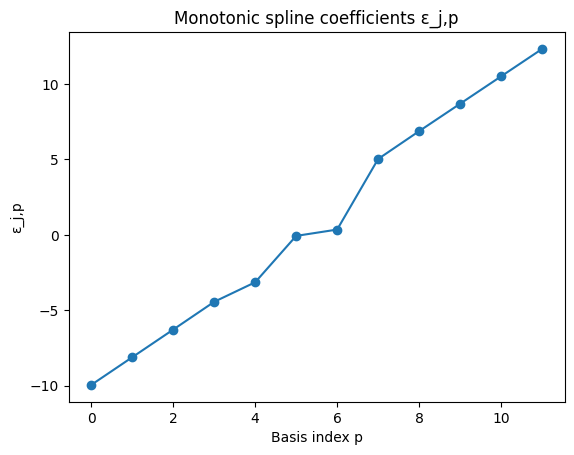

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9211, -8.0973, -6.2686, -4.4415, -2.5807, -0.6055,  0.7722,  3.5389,
         6.3006,  8.1188,  9.9369, 11.7551])


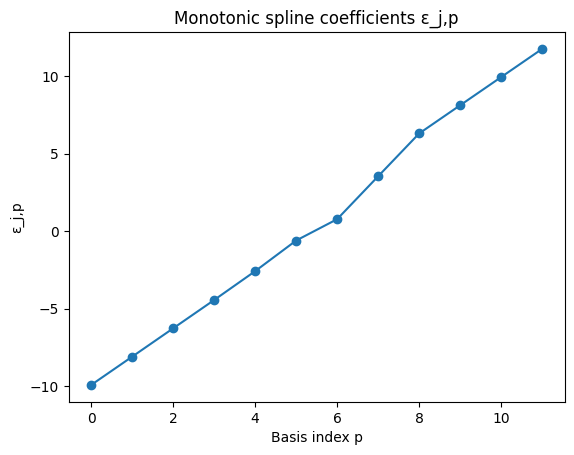

In [37]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

In [38]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [39]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.4322
KLD GTM      Train Data:  0.0718
KLD Gaussian Train Data:  -0.311
KLD Copula   Train Data:  0.5399

KLD BGTM      Test  Data:  0.4377
KLD GTM      Test  Data:  0.0774
KLD Gaussian Test  Data:  -0.2851
KLD Copula   Test  Data:  0.5472


In [40]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

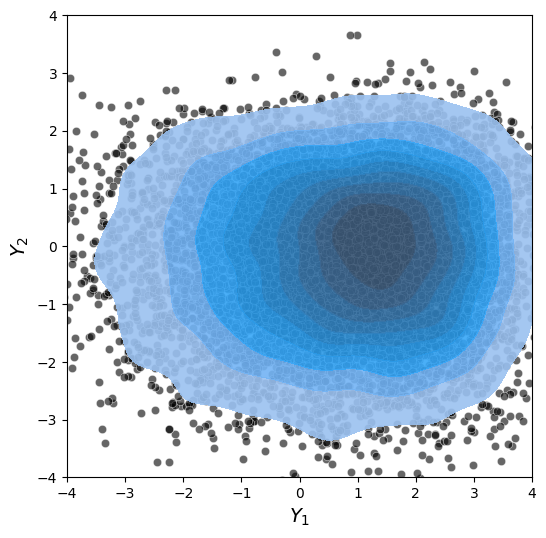

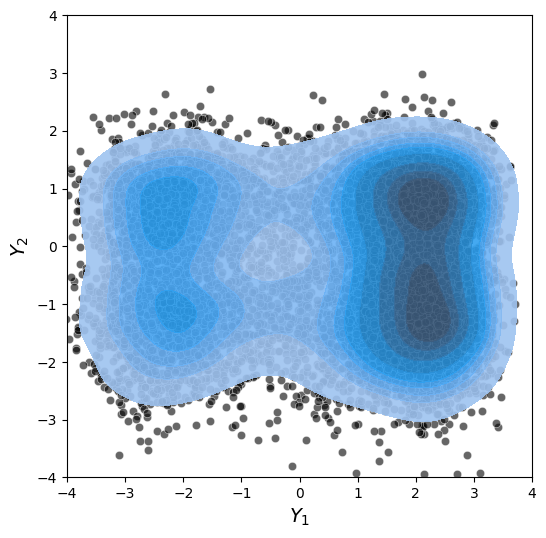

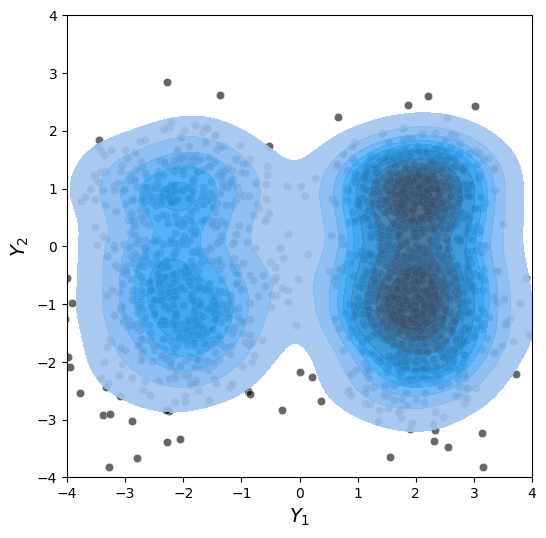

In [41]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])